In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms import functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, RandomCrop

In [2]:
%load_ext tensorboard

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import os
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [5]:
size_h = size_w = 32
image_mean = [0.4914, 0.4822, 0.4465]
image_std = [0.2023, 0.1994, 0.2010]
batch_size = 2048

trans_aug = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

trans = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)])

In [6]:
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=trans
)

train_dataset_aug = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=trans_aug
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=trans
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_dataset_concat = ConcatDataset([train_dataset, train_dataset_aug])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
#train_loader = DataLoader(dataset=train_dataset_concat, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

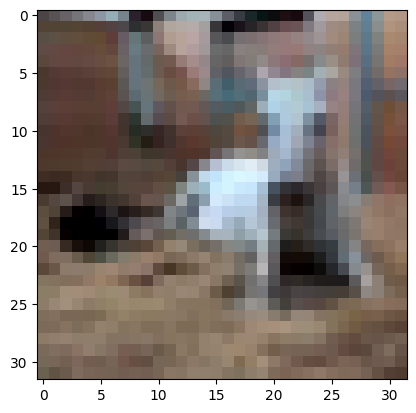

In [8]:
def imshow(imgs):
    image_to_show = imgs.transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    plt.imshow(image_to_show)
    
    


# get some random training images
for images, labels in train_loader:
    break

# show images
imshow(torchvision.utils.make_grid(images[0]))

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, use_BN=True, dropout=0.0, skip=True, activation=nn.ReLU(inplace=False)):
        super(ResidualBlock, self).__init__()
        self.skip = skip
        self.activation = activation
        if use_BN:
            self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.Dropout(dropout),
                activation,
                nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.Dropout(dropout)
            )
        else:
            self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
                activation,
                nn.Dropout(dropout),
                nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout)
            )
        if skip:
            self.shortcut = nn.Sequential()
        if (stride != 1 or inchannel != outchannel) and skip:
            if use_BN:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                    nn.Dropout(dropout),
                    nn.BatchNorm2d(outchannel)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                    nn.Dropout(dropout)
                )
            
    def forward(self, x):
        out = self.left(x)
        if self.skip:
            out = out + self.shortcut(x)
        out = self.activation(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10, use_BN=True, dropout=0.0, width=1, depth=2, skip=True, init='kaiming', activation=nn.ReLU(inplace=False)):
        super(ResNet, self).__init__()
        self.inchannel = 16*width
        self.use_BN = use_BN
        self.activation = activation
        self.dropout = dropout
        self.skip = skip
        if use_BN:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 16*width, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout),
                nn.BatchNorm2d(16*width),
                activation
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 16*width, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout(dropout),
                activation
            )
        self.layer1 = self.make_layer(ResidualBlock, 16*width, depth, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 32*width, depth, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 64*width, depth, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 64*width, depth, stride=2)        
        self.fc = nn.Linear(16, 1)
        if init is not None:
            self.init_weights(init)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride, self.use_BN, self.dropout, self.skip, self.activation))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def init_weights(self, init):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init == 'kaiming':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif init == 'xavier':
                    nn.init.xavier_normal_(m.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        feature_map = self.layer4(out)
        # out = F.avg_pool2d(out, 4)
        # print(out.shape)
        # out = out.view(out.size(0), -1)
        batch, channnels, h, w = feature_map.shape
        out = self.fc(feature_map.reshape(batch, channnels, h * w))
        return feature_map, out

In [11]:
def ResNet18(num_classes=10, use_BN=True, dropout=0.0, width=1, depth=2, skip=True, init='kaiming', activation=nn.ReLU(inplace=False)):
    return ResNet(ResidualBlock, num_classes=num_classes, use_BN=use_BN, dropout=dropout, width=width, depth=depth, skip=skip, init=init, activation=activation)

In [12]:
class ConvMI_NN(nn.Module):
    def __init__(self, input_channels, feature_map_size, num_classes=2):
        super(ConvMI_NN, self).__init__()
        
        self.input_channels = input_channels
        self.feature_map_size = feature_map_size
        self.num_classes = num_classes

        self.conv  = nn.Conv2d(self.input_channels, 1, kernel_size=1, stride=1, bias=False)
        self.fc = nn.Linear(self.feature_map_size, self.num_classes)

    def forward(self, x):
        out = nn.ReLU(inplace=False)(self.conv(x))
        out = torch.flatten(out, start_dim=1)
        return self.fc(out)
    
class MI1x1ConvNet(nn.Module):
    """Simple custorm 1x1 convnet.
    """
    def __init__(self, n_input, n_units,):
        """
        Args:
            n_input: Number of input units.
            n_units: Number of output units.
        """

        super().__init__()

        self.block_nonlinear = nn.Sequential(
            nn.Conv2d(n_input, n_units, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_units),
            nn.ReLU(inplace=False),
            nn.Conv2d(n_units, n_units, kernel_size=1, stride=1, padding=0, bias=True),
        )

        self.block_ln = nn.Sequential(
            torchvision.ops.Permute([0, 2, 3, 1]),
            nn.LayerNorm(n_units),
            nn.ReLU(inplace=False),
            torchvision.ops.Permute([0, 3, 1, 2])
        )

        self.linear_shortcut = nn.Conv2d(n_input, n_units, kernel_size=1,
                                         stride=1, padding=0, bias=False)

        # initialize shortcut to be like identity (if possible)
        if n_units >= n_input:
            eye_mask = np.zeros((n_units, n_input, 1, 1), dtype=np.uint8)
            for i in range(n_input):
                eye_mask[i, i, 0, 0] = 1
            self.linear_shortcut.weight.data.uniform_(-0.01, 0.01)
            self.linear_shortcut.weight.data.masked_fill_(torch.tensor(eye_mask), 1.)

    def forward(self, x):
        """
            Args:
                x: Input tensor.
            Returns:
                torch.Tensor: network output.
        """

        h = self.block_ln(self.block_nonlinear(x) + self.linear_shortcut(x))
        return h

In [13]:
def infonce_loss(l, m):
    '''Computes the noise contrastive estimation-based loss, a.k.a. infoNCE.
    Note that vectors should be sent as 1x1.
    Args:
        l: Local feature map.
        m: Multiple globals feature map.
    Returns:
        torch.Tensor: Loss.
    '''
    N, units, n_locals = l.size()
    _, _ , n_multis = m.size()

    # First we make the input tensors the right shape.
    l_p = l.permute(0, 2, 1)
    m_p = m.permute(0, 2, 1)

    l_n = l_p.reshape(-1, units)
    m_n = m_p.reshape(-1, units)

    # Inner product for positive samples. Outer product for negative. We need to do it this way
    # for the multiclass loss. For the outer product, we want a N x N x n_local x n_multi tensor.
    u_p = torch.matmul(l_p, m).unsqueeze(2)
    u_n = torch.mm(m_n, l_n.t())
    u_n = u_n.reshape(N, n_multis, N, n_locals).permute(0, 2, 3, 1)

    # We need to mask the diagonal part of the negative tensor.
    mask = torch.eye(N)[:, :, None, None].to(l.device)
    n_mask = 1 - mask

    # Masking is done by shifting the diagonal before exp.
    u_n = (n_mask * u_n) - (10. * (1 - n_mask))  # mask out "self" examples
    u_n = u_n.reshape(N, N * n_locals, n_multis).unsqueeze(dim=1).expand(-1, n_locals, -1, -1)

    # Since this is multiclass, we concat the positive along the class dimension before performing log softmax.
    pred_lgt = torch.cat([u_p, u_n], dim=2)
    pred_log = F.log_softmax(pred_lgt, dim=2)

    # The positive score is the first element of the log softmax.
    loss = -pred_log[:, :, 0].sum()

    return loss

In [14]:
import math

def get_positive_expectation(p_samples, measure, average=False):
    """Computes the positive part of a divergence / difference.
    Args:
        p_samples: Positive samples.
        measure: Measure to compute for.
        average: Average the result over samples.
    Returns:
        torch.Tensor
    """
    log_2 = math.log(2.)

    if measure == 'GAN':
        Ep = - F.softplus(-p_samples)
    elif measure == 'JSD':
        Ep = log_2 - F.softplus(-p_samples)  # Note JSD will be shifted
    elif measure == 'X2':
        Ep = p_samples ** 2
    elif measure == 'KL':
        Ep = p_samples
    elif measure == 'RKL':
        Ep = -torch.exp(-p_samples)
    elif measure == 'DV':
        Ep = p_samples
    elif measure == 'H2':
        Ep = 1. - torch.exp(-p_samples)
    elif measure == 'W1':
        Ep = p_samples
    else:
        raise_measure_error(measure)

    if average:
        return Ep.mean()
    else:
        return Ep

def get_negative_expectation(q_samples, measure, average=False):
    """Computes the negative part of a divergence / difference.
    Args:
        q_samples: Negative samples.
        measure: Measure to compute for.
        average: Average the result over samples.
    Returns:
        torch.Tensor
    """
    log_2 = math.log(2.)

    if measure == 'GAN':
        Eq = F.softplus(-q_samples) + q_samples
    elif measure == 'JSD':
        Eq = F.softplus(-q_samples) + q_samples - log_2  # Note JSD will be shifted
    elif measure == 'X2':
        Eq = -0.5 * ((torch.sqrt(q_samples ** 2) + 1.) ** 2)
    elif measure == 'KL':
        Eq = torch.exp(q_samples - 1.)
    elif measure == 'RKL':
        Eq = q_samples - 1.
    elif measure == 'DV':
        Eq = log_sum_exp(q_samples, 0) - math.log(q_samples.size(0))
    elif measure == 'H2':
        Eq = torch.exp(q_samples) - 1.
    elif measure == 'W1':
        Eq = q_samples
    else:
        raise_measure_error(measure)

    if average:
        return Eq.mean()
    else:
        return Eq


def fenchel_dual_loss(l, m, measure='JSD'):
    '''Computes the f-divergence distance between positive and negative joint distributions.
    Note that vectors should be sent as 1x1.
    Divergences supported are Jensen-Shannon `JSD`, `GAN` (equivalent to JSD),
    Squared Hellinger `H2`, Chi-squeared `X2`, `KL`, and reverse KL `RKL`.
    Args:
        l: Local feature map.
        m: Multiple globals feature map.
        measure: f-divergence measure.
    Returns:
        torch.Tensor: Loss.
    '''
    N, units, n_locals = l.size()
    n_multis = m.size(2)

    # First we make the input tensors the right shape.
    l = l.view(N, units, n_locals)
    l = l.permute(0, 2, 1)
    l = l.reshape(-1, units)

    m = m.view(N, units, n_multis)
    m = m.permute(0, 2, 1)
    m = m.reshape(-1, units)

    # Outer product, we want a N x N x n_local x n_multi tensor.
    u = torch.mm(m, l.t())
    u = u.reshape(N, n_multis, N, n_locals).permute(0, 2, 3, 1)

    # Since we have a big tensor with both positive and negative samples, we need to mask.
    mask = torch.eye(N).to(l.device)
    n_mask = 1 - mask

    # Compute the positive and negative score. Average the spatial locations.
    E_pos = get_positive_expectation(u, measure, average=False).mean(2).mean(2)
    E_neg = get_negative_expectation(u, measure, average=False).mean(2).mean(2)

    # Mask positive and negative terms for positive and negative parts of loss
    E_pos = (E_pos * mask).sum() / mask.sum()
    E_neg = (E_neg * n_mask).sum() / n_mask.sum()
    loss = E_neg - E_pos

    return loss

In [15]:
class Classifier_NN(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(Classifier_NN, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.block = nn.Sequential(
            nn.Linear(self.input_dim, 1000),
            nn.ReLU(inplace=False),
            nn.Linear(1000, 200),
            nn.ReLU(inplace=False),
            nn.Linear(200, self.num_classes)
        )

    def forward(self, x):
        return self.block(x)

In [16]:
class SubSeq_NN(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(SubSeq_NN, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.block = nn.Sequential(
            nn.Linear(self.input_dim, 1000),
            nn.ReLU(inplace=False),
            nn.Linear(1000, 200),
            nn.ReLU(inplace=False),
            nn.Linear(200, self.num_classes)
        )

    def forward(self, x, subseq):
        x = torch.squeeze(torch.cat([x, subseq], 1))
        out = self.block(x)
        if out.shape[1] > 2:
            out[:, 2:] = nn.Sigmoid()(out[:, 2:])
        return out

In [17]:
writer = SummaryWriter(log_dir=f"logs/SubSeq")

In [65]:
def train_epoch(dataloader, model_enc, minet_local, minet_global, loss_fn, optimizer_enc, 
                optimizer_mi_loc, optimizer_mi_glob, device, writer=writer):
    model_enc.train()
    minet_local.train()
    minet_global.train()
    
    for idx, (x, label) in enumerate(dataloader):
        optimizer_enc.zero_grad()
        optimizer_mi_loc.zero_grad()
        optimizer_mi_glob.zero_grad()
        
        x, label = x.to(device), label.to(device)
        feture_map, y = model_enc(x)
        
#         joint = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[:,:, None, None]
#         joint = torch.cat([feture_map, joint], dim=1)
#         marg_idx = torch.tensor(np.random.choice(x.shape[0], x.shape[0]))
#         marginal = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[marg_idx,:, None, None]
#         marginal = torch.cat([feture_map, marginal], dim=1)
#         labels_joint = torch.ones(joint.shape[0], dtype=torch.long).to(device)
#         labels_marginal = torch.zeros(marginal.shape[0], dtype=torch.long).to(device)

#         #outputs = model_mi(torch.cat([joint, marginal]))
#         outputs_j = model_mi(joint)
#         outputs_m = model_mi(marginal)
#         N, local_units = outputs_j.size()[:2]
#         outputs_j = outputs_j.view(N, local_units, -1)
#         N, local_units = outputs_m.size()[:2]
#         outputs_m = outputs_m.view(N, local_units, -1)

        L = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[:,:, None, None]
        L = torch.cat([feture_map, L], dim=1)
        L = minet_local(L).cpu()
        N, local_units = L.size()[:2]
        L = L.view(N, local_units, -1)
        
        G = torch.ones(x.shape[0], 128, 32, 32).to(device) * y.squeeze()[:,:, None, None]
        G = torch.cat([x, G], dim=1)
        G = minet_global(G).cpu()
        N, local_units = G.size()[:2]
        G = G.view(N, local_units, -1)
        
        #loss = loss_fn(outputs, torch.cat([labels_joint, labels_marginal]))
        loss = loss_fn(L, G)
        loss.backward()
        optimizer_enc.step()
        optimizer_mi_loc.step()
        optimizer_mi_glob.step()
    
def evaluate(dataloader, model_enc, minet_local, minet_global, loss_fn, device, writer=writer):
    model_enc.eval()
    minet_local.eval()
    minet_global.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, (x, label) in enumerate(dataloader):
            x, label = x.to(device), label.to(device)
            feture_map, y = model_enc(x)
            
#             joint = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[:,:, None, None]
#             joint = torch.cat([feture_map, joint], dim=1)
#             marg_idx = torch.tensor(np.random.choice(x.shape[0], x.shape[0]))
#             marginal = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[marg_idx,:, None, None]
#             marginal = torch.cat([feture_map, marginal], dim=1)
#             labels_joint = torch.ones(joint.shape[0], dtype=torch.long).to(device)
#             labels_marginal = torch.zeros(marginal.shape[0], dtype=torch.long).to(device)

#             outputs_j = model_mi(joint)
#             outputs_m = model_mi(marginal)
#             N, local_units = outputs_j.size()[:2]
#             outputs_j = outputs_j.view(N, local_units, -1)
#             N, local_units = outputs_m.size()[:2]
#             outputs_m = outputs_m.view(N, local_units, -1)

            L = torch.ones(x.shape[0], 128, 4, 4).to(device) * y.squeeze()[:,:, None, None]
            L = torch.cat([feture_map, L], dim=1)
            L = minet_local(L).detach().cpu()
            N, local_units = L.size()[:2]
            L = L.view(N, local_units, -1)

            G = torch.ones(x.shape[0], 128, 32, 32).to(device) * y.squeeze()[:,:, None, None]
            G = torch.cat([x, G], dim=1)
            G = minet_global(G).detach().cpu()
            N, local_units = G.size()[:2]
            G = G.view(N, local_units, -1)

            #loss = loss_fn(outputs, torch.cat([labels_joint, labels_marginal]))
            loss = loss_fn(L, G)
            
            #y_true = torch.cat([labels_joint, labels_marginal])
            total_loss += float(loss.detach())
            #_, predicted = torch.max(outputs.data, 1)

            #total_accuracy += predicted.eq(y_true.data).cpu().sum()
    return total_loss / (len(dataloader.dataset)*2), -1#, total_accuracy / (len(dataloader.dataset)*2)
    

def train(
    train_loader, test_loader, model_enc, minet_local, minet_global, loss_fn, optimizer_enc, 
    optimizer_mi_loc, optimizer_mi_glob, device, num_epochs, scheduler=None, writer=writer
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    best_acc = 0
    for epoch in tqdm(range(num_epochs)):
        train_epoch(train_loader, model_enc, minet_local, minet_global, loss_fn, 
                    optimizer_enc, optimizer_mi_loc, optimizer_mi_glob, device, writer=writer, epoch=epoch)
        
        train_loss, train_acc = evaluate(train_loader, model_enc, minet_local, 
                                         minet_global, loss_fn, device, writer=writer, epoch=epoch)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        writer.add_scalar("loss / train", train_loss, epoch)
        writer.add_scalar("accuracy / train", train_acc, epoch)
        
        test_loss, test_acc = evaluate(test_loader, model_enc, minet_local, 
                                       minet_global, loss_fn, device, writer=writer, epoch=epoch)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        writer.add_scalar("loss / test", test_loss, epoch)
        writer.add_scalar("accuracy / test", test_acc, epoch)
        for name, param in model_enc.named_parameters():
            writer.add_histogram(name, param.data, epoch)
        for name, param in minet_local.named_parameters():
            writer.add_histogram(name, param.data, epoch)
        if scheduler is not None:
            scheduler.step()
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
        if test_acc > best_acc:
            torch.save(model_enc.state_dict(), 'model_enc_best_test.pt')
    torch.save(model_enc.state_dict(), 'model_enc_last_test.pt')
    return train_losses, train_accuracies, test_losses, test_accuracies

In [54]:
def get_patches(images, patch_size, stride):
    batch = images.shape[0]
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    h_patches, w_patches = patches.shape[2], patches.shape[3]
    h_idx_ = torch.tensor(np.random.choice(h_patches, batch))
    w_idx_ = torch.tensor(np.random.choice(w_patches, batch))
    sub_img = transforms.Resize(32)(patches[list(range(batch)),:, h_idx_, w_idx_, :, :].clone())
    
    h_idx = torch.tensor(np.random.choice(h_patches, batch))
    w_idx = torch.tensor(np.random.choice(w_patches, batch))
    patch_1 = transforms.Resize(32)(patches[list(range(batch)),:, h_idx, w_idx, :, :].clone())

    h_idx_2 = torch.tensor(np.random.choice(h_patches, batch))
    w_idx_2 = torch.tensor(np.random.choice(w_patches, batch))
    h_idx_2[(h_idx_2==h_idx) & (w_idx_2==w_idx)] = 0 
    w_idx_2[(h_idx_2==h_idx) & (w_idx_2==w_idx)] = 0
    patch_2 = transforms.Resize(32)(patches[list(range(batch)),:, h_idx_2, w_idx_2, :, :].clone())
    return sub_img, patch_1, patch_2, h_idx_.to(device), w_idx_.to(device)

In [55]:
def predict_cosine(out_cos):
    predicted = torch.ones(out_cos.shape[0], dtype=torch.long)
    predicted[out_cos < 0.5] = 0 
    return predicted

In [56]:
import random

def first_loss(y, y_crop, minet_local, loss_fn, batch_size, i, j, crop_size):    
    # out_pos = minet_local(y, y_crop)
    out_pos = torch.nn.CosineSimilarity()(y.cpu(), y_crop.cpu()).squeeze()
    out_pos[out_pos < 0] *= (-1)
    #loss = minet_local(y.squeeze(), y_crop.squeeze(), torch.ones(y.shape[0], dtype=torch.long))
    
    out = minet_local(y.squeeze(), y_crop.squeeze())
    loss = loss_fn(out, torch.ones(y.shape[0], dtype=torch.float))
    
    # loss = loss_fn(out_pos[:, :2], torch.ones(out_pos.shape[0], dtype=torch.long).to(device))
    # loss_mse = nn.MSELoss(reduction='sum')(out_pos[:, 2], 
    #                             torch.ones(out_pos.shape[0], dtype=torch.long).to(device) * (i+crop_size) / 64)
    # loss_mse += nn.MSELoss(reduction='sum')(out_pos[:, 3], 
    #                             torch.ones(out_pos.shape[0], dtype=torch.long).to(device) * (j+crop_size) / 64)
    
    idx = list(range(batch_size))
    random.shuffle(idx)
    idx = torch.tensor(idx)
    # out_neg = minet_local(y, y_crop[idx])
    # loss += loss_fn(out_neg[:, :2], torch.zeros(out_neg.shape[0], dtype=torch.long).to(device))
                       
    #loss += minet_local(y.squeeze(), y_crop[idx].squeeze(), torch.zeros(y.shape[0], dtype=torch.long))
    
    out = minet_local(y.squeeze(), y_crop[idx].squeeze())
    loss += loss_fn(out, torch.zeros(y.shape[0], dtype=torch.float))
    loss_mse = 0
    out_neg = torch.nn.CosineSimilarity()(y.cpu(), y_crop[idx].cpu()).squeeze()
    out_neg[out_neg < 0] *= (-1)
    return loss, loss_mse, out_pos, out_neg

In [57]:
def second_loss(y_sub, y_crop_1, y_crop_2, minet_local, loss_fn, enc_update=True):
    if enc_update:
        # minet_local.eval()
        # with torch.no_grad():
        #     output = minet_local(y_crop_1, y_crop_2)
        #     return loss_fn(output[:, :2], torch.zeros(output.shape[0], dtype=torch.long).to(device))
        #return minet_local(y_crop_1.squeeze().cpu(), y_crop_2.squeeze().cpu(), torch.zeros(y_crop_1.shape[0], dtype=torch.long))
        out = minet_local(y_crop_1.squeeze().cpu(), y_crop_2.squeeze().cpu())
        # print(out)
        # print(out[out > 1])
        # print(out[out < 0])
        return loss_fn(out, torch.zeros(y_sub.shape[0], dtype=torch.float))
    else:
#         minet_local.train()
#         output = minet_local(y_crop_1, y_crop_2)
#         output_neg = minet_local(y_sub, y_crop_1)
        
#         loss_neg = loss_fn(output_neg[:, :2], torch.zeros(output_neg.shape[0], dtype=torch.long).to(device))
#         loss_pos = loss_fn(output[:, :2], torch.ones(output.shape[0], dtype=torch.long).to(device))
#         return (loss_pos + loss_neg) / 2
        loss_neg = minet_local(y_crop_1.squeeze(), y_sub.squeeze(), torch.zeros(y_crop_1.shape[0], dtype=torch.long))
        loss_pos = minet_local(y_crop_1.squeeze(), y_crop_2.squeeze(), torch.ones(y_crop_1.shape[0], dtype=torch.long))
        return (loss_neg + loss_neg) / 2

In [58]:
mse_coef = 15

def train_epoch(dataloader, model_enc, minet_local, minet_global, loss_fn, optimizer_enc, 
                optimizer_mi_loc, optimizer_mi_glob, device, writer, epoch):
    model_enc.train()
    minet_local.train()
    
    for batch, (x, label) in enumerate(dataloader):
        optimizer_enc.zero_grad()
        #optimizer_mi_loc.zero_grad()
        if optimizer_mi_glob is not None:
            optimizer_mi_glob.zero_grad()
        
        x, label = x.to(device), label.to(device)
        crop_size = np.random.randint(1, 32)
        i, j, h, w = RandomCrop(crop_size).get_params(x, output_size=(crop_size, crop_size))
        x_crop = transforms.Resize(32)(F.crop(x, i, j, h, w))
        
        patch_size = stride = np.random.randint(4, 16)
        sub_img, patch_1, patch_2, _, _ = get_patches(x, patch_size, stride)
        
        feture_map, y = model_enc(torch.cat([x, x_crop, sub_img, patch_1, patch_2])) 
        y, y_crop, y_sub, y_crop_1, y_crop_2 = torch.split(y, x.size(0))
        
        loss, loss_mse, _, _ = first_loss(y, y_crop, minet_local, loss_fn, x.shape[0], i, j, crop_size)
        #print(loss)
        
        writer.add_scalar(
            "batch loss entropy / train", loss.item() / (x.shape[0]*2), epoch * len(dataloader) + batch
        )
        # writer.add_scalar(
        #     "batch loss mse / train", mse_coef*loss_mse.item() / (x.shape[0]*2), epoch * len(dataloader) + batch
        # )
        # loss += mse_coef*loss_mse
        # loss /= (x.shape[0]*2*(mse_coef + 1))
        
        loss /= (x.shape[0]*2)
        
        # writer.add_scalar(
        #     "batch loss sum / train", loss.item(), epoch * len(dataloader) + batch
        # )
        
        if optimizer_mi_glob is not None:
            optimizer_mi_glob.step()
            
        # feture_map, y = model_enc(torch.cat([sub_img, patch_1, patch_2])) 
        # y_sub, y_crop_1, y_crop_2 = torch.split(y, x.size(0))
        
        # loss_second = second_loss(y_sub, y_crop_1, y_crop_2, minet_local, loss_fn, enc_update=True) / x.shape[0]
        # writer.add_scalar(
        #     "batch loss encoder patch-patch / train", loss_second.item(), epoch * len(dataloader) + batch
        # )
        # loss += loss_second
        loss.backward()
        optimizer_enc.step()
        #optimizer_mi_loc.step()
        
        # feture_map, y = model_enc(torch.cat([sub_img, patch_1, patch_2])) 
        # y_sub, y_crop_1, y_crop_2 = torch.split(y, x.size(0))
        # #optimizer_mi_loc.zero_grad()
        # idx = list(range(x.shape[0]))
        # random.shuffle(idx)
        # idx = torch.tensor(idx)
        # loss = second_loss(y_sub[idx], y_crop_1, y_crop_2, minet_local, loss_fn, enc_update=False) / x.shape[0]
        # writer.add_scalar(
        #     "batch loss discriminator patch-patch / train", loss.item(), epoch * len(dataloader) + batch
        # )
        # loss.backward()
        # #optimizer_mi_loc.step()
        # optimizer_enc.step()
        torch.cuda.empty_cache()
    
def evaluate(dataloader, model_enc, minet_local, minet_global, loss_fn, device, writer, epoch):
    model_enc.eval()
    #minet_local.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    
    out_i_all, out_j_all = torch.tensor([]), torch.tensor([])
    pos_i, pos_j = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        for idx, (x, label) in enumerate(dataloader):
            x, label = x.to(device), label.to(device)
            crop_size = np.random.randint(1, 32)
            i, j, h, w = RandomCrop(crop_size).get_params(x, output_size=(crop_size, crop_size))
            x_crop = transforms.Resize(32)(F.crop(x, i, j, h, w))

            patch_size = stride = np.random.randint(4, 16)
            sub_img, patch_1, patch_2, _, _ = get_patches(x, patch_size, stride)

            feture_map, y = model_enc(torch.cat([x, x_crop, sub_img, patch_1, patch_2])) 
            y, y_crop, y_sub, y_crop_1, y_crop_2 = torch.split(y, x.size(0))

            loss, loss_mse, out_pos, out_neg = first_loss(y, y_crop, minet_local, loss_fn, x.shape[0], i, j, crop_size)
            # loss += mse_coef*loss_mse
            # loss /= (mse_coef + 1)
            
            loss /= (x.shape[0]*2)
            
            predicted = torch.ones(out_pos.shape[0], dtype=torch.long)
            predicted[out_pos < 0.5] = 0 
            #_, predicted = torch.max(out_pos.data[:, :2], 1)
            total_accuracy += predicted.eq(torch.ones(out_pos.shape[0], dtype=torch.long).data).cpu().sum()
            
            total_loss += float(loss.detach())
            predicted = torch.ones(out_neg.shape[0], dtype=torch.long)
            predicted[out_neg < 0.5] = 0 
            #_, predicted = torch.max(out_neg.data, 1)
            total_accuracy += predicted.eq(torch.zeros(out_neg.shape[0], dtype=torch.long).data).cpu().sum()
        torch.cuda.empty_cache()
    return total_loss, total_accuracy / (len(dataloader.dataset)*2)

In [59]:
class CosineLoss(nn.Module):
    def forward(self, x, y):
        cos = torch.nn.CosineSimilarity()(x.cpu(), y.cpu())
        cos[cos < 0] *= (-1)
        cos[cos > 1] = 1 - 1e-8
        cos[cos < 0] = 1e-8
        #cos[label == 1] = 1 - cos[label == 1]
        return cos#.sum()

In [25]:
def plot(losses, labels, num_epoch, title, xlabel, ylabel):
    plt.figure(figsize=(8,5))
    for loss, label in zip(losses, labels):
        plt.plot(range(1, num_epoch+1), loss, label=label)
    
    plt.title(title, fontsize=12)
    plt.grid(True)
    plt.xticks(range(1, num_epoch, 3))
    plt.ylabel(ylabel,  fontsize=12)
    plt.xlabel(xlabel,  fontsize=12)
    plt.legend(fontsize=10)

In [22]:
resnet = ResNet18(width=2).to(device)
#mi_net = ConvMI_NN(input_channels=128*2, feature_map_size=16, num_classes=2).to(device)
minet_local = MI1x1ConvNet(n_input=128*2, n_units=512).to(device)
minet_global = MI1x1ConvNet(n_input=128+3, n_units=512).to(device)

#criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = infonce_loss
criterion = fenchel_dual_loss
optimizer_enc = torch.optim.Adam(resnet.parameters(), lr=1e-4)
optimizer_mi_loc = torch.optim.Adam(minet_local.parameters(), lr=1e-4)
optimizer_mi_glob = torch.optim.Adam(minet_global.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_enc, step_size=100, gamma=0.3)

/tmp/ipykernel_6246/1126233747.py:52: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  self.linear_shortcut.weight.data.masked_fill_(torch.tensor(eye_mask), 1.)


In [26]:
writer = SummaryWriter(log_dir=f"logs/SubSeq")

In [60]:
resnet = ResNet18(width=2).to(device)
#mi_net = ConvMI_NN(input_channels=128*2, feature_map_size=16, num_classes=2).to(device)
minet_local = SubSeq_NN(input_dim=128*2, num_classes=4).to(device)
minet_global = None

minet_local = CosineLoss()

#criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = torch.nn.BCELoss(reduction='sum')
#criterion = infonce_loss
#criterion = fenchel_dual_loss
optimizer_enc = torch.optim.Adam(resnet.parameters(), lr=1e-5)
optimizer_mi_loc = None #torch.optim.Adam(minet_local.parameters(), lr=1e-5)
optimizer_mi_glob = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_enc, step_size=20, gamma=0.5)

In [64]:
torch.save(resnet.state_dict(), 'model_enc_last_test.pt')

In [754]:
resnet.load_state_dict(torch.load('resnet_subseq_lr.pt'))#.to(device)
minet_local.load_state_dict(torch.load('minet_local_subseq_lr.pt'))#.to(device)

<All keys matched successfully>

In [766]:
evaluate(test_loader, resnet, minet_local, 
            minet_global, criterion, device, writer=writer, epoch=1001)

tensor(-0.3170)
tensor(-0.1834)


(0.13985859508514403, tensor(0.7147))

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = \
      train(train_loader, test_loader, resnet, minet_local, minet_global, criterion, optimizer_enc, 
            optimizer_mi_loc, optimizer_mi_glob, device, num_epochs=1000, scheduler=scheduler, writer=writer)

  0%|          | 1/1000 [00:55<15:30:10, 55.87s/it]

Epoch: 1/1000. Loss (Train/Test): 17.402/3.556. Accuracy (Train/Test): 0.588/0.569


  0%|          | 2/1000 [01:51<15:31:32, 56.00s/it]

Epoch: 2/1000. Loss (Train/Test): 16.088/2.977. Accuracy (Train/Test): 0.628/0.684


  0%|          | 3/1000 [02:48<15:30:49, 56.02s/it]

Epoch: 3/1000. Loss (Train/Test): 16.361/3.377. Accuracy (Train/Test): 0.622/0.583


  0%|          | 4/1000 [03:44<15:31:40, 56.12s/it]

Epoch: 4/1000. Loss (Train/Test): 16.190/3.106. Accuracy (Train/Test): 0.634/0.668


  0%|          | 5/1000 [04:40<15:29:19, 56.04s/it]

Epoch: 5/1000. Loss (Train/Test): 15.923/3.217. Accuracy (Train/Test): 0.651/0.643


  1%|          | 6/1000 [05:36<15:30:21, 56.16s/it]

Epoch: 6/1000. Loss (Train/Test): 15.611/2.788. Accuracy (Train/Test): 0.673/0.777


  1%|          | 7/1000 [06:32<15:29:40, 56.17s/it]

Epoch: 7/1000. Loss (Train/Test): 15.757/3.194. Accuracy (Train/Test): 0.665/0.644


  1%|          | 8/1000 [07:28<15:27:13, 56.08s/it]

Epoch: 8/1000. Loss (Train/Test): 15.484/3.294. Accuracy (Train/Test): 0.679/0.611


  1%|          | 9/1000 [08:25<15:28:14, 56.20s/it]

Epoch: 9/1000. Loss (Train/Test): 15.645/3.128. Accuracy (Train/Test): 0.669/0.646


  1%|          | 10/1000 [09:21<15:26:56, 56.18s/it]

Epoch: 10/1000. Loss (Train/Test): 15.301/2.905. Accuracy (Train/Test): 0.688/0.738


  1%|          | 11/1000 [10:16<15:22:31, 55.97s/it]

Epoch: 11/1000. Loss (Train/Test): 15.116/3.121. Accuracy (Train/Test): 0.705/0.676


  1%|          | 12/1000 [11:12<15:21:51, 55.98s/it]

Epoch: 12/1000. Loss (Train/Test): 15.393/3.116. Accuracy (Train/Test): 0.682/0.673


  1%|▏         | 13/1000 [12:08<15:21:11, 56.00s/it]

Epoch: 13/1000. Loss (Train/Test): 15.142/3.220. Accuracy (Train/Test): 0.699/0.635


  1%|▏         | 14/1000 [13:04<15:19:39, 55.96s/it]

Epoch: 14/1000. Loss (Train/Test): 14.783/3.110. Accuracy (Train/Test): 0.714/0.661


  2%|▏         | 15/1000 [14:00<15:19:11, 55.99s/it]

Epoch: 15/1000. Loss (Train/Test): 14.660/2.761. Accuracy (Train/Test): 0.713/0.782


  2%|▏         | 16/1000 [14:56<15:17:33, 55.95s/it]

Epoch: 16/1000. Loss (Train/Test): 14.549/2.866. Accuracy (Train/Test): 0.711/0.728


  2%|▏         | 17/1000 [15:52<15:16:43, 55.95s/it]

Epoch: 17/1000. Loss (Train/Test): 14.558/3.153. Accuracy (Train/Test): 0.714/0.644


  2%|▏         | 18/1000 [16:48<15:15:16, 55.92s/it]

Epoch: 18/1000. Loss (Train/Test): 14.546/2.811. Accuracy (Train/Test): 0.716/0.740


  2%|▏         | 19/1000 [17:44<15:15:40, 56.01s/it]

Epoch: 19/1000. Loss (Train/Test): 14.339/2.994. Accuracy (Train/Test): 0.728/0.694


  2%|▏         | 20/1000 [18:40<15:12:23, 55.86s/it]

Epoch: 20/1000. Loss (Train/Test): 14.205/2.925. Accuracy (Train/Test): 0.721/0.707


  2%|▏         | 21/1000 [19:36<15:14:23, 56.04s/it]

Epoch: 21/1000. Loss (Train/Test): 13.800/2.717. Accuracy (Train/Test): 0.743/0.750


  2%|▏         | 22/1000 [20:32<15:12:28, 55.98s/it]

Epoch: 22/1000. Loss (Train/Test): 13.863/3.014. Accuracy (Train/Test): 0.740/0.676


  2%|▏         | 23/1000 [21:28<15:10:10, 55.90s/it]

Epoch: 23/1000. Loss (Train/Test): 14.261/2.890. Accuracy (Train/Test): 0.726/0.713


  2%|▏         | 24/1000 [22:24<15:11:12, 56.02s/it]

Epoch: 24/1000. Loss (Train/Test): 13.970/2.490. Accuracy (Train/Test): 0.733/0.818


  2%|▎         | 25/1000 [23:21<15:13:38, 56.22s/it]

Epoch: 25/1000. Loss (Train/Test): 14.895/2.475. Accuracy (Train/Test): 0.689/0.803


  3%|▎         | 26/1000 [24:16<15:09:48, 56.05s/it]

Epoch: 26/1000. Loss (Train/Test): 14.161/2.537. Accuracy (Train/Test): 0.718/0.798


  3%|▎         | 27/1000 [25:12<15:08:15, 56.01s/it]

Epoch: 27/1000. Loss (Train/Test): 13.750/2.446. Accuracy (Train/Test): 0.733/0.822


  3%|▎         | 28/1000 [26:08<15:08:16, 56.07s/it]

Epoch: 28/1000. Loss (Train/Test): 14.410/2.958. Accuracy (Train/Test): 0.706/0.690


  3%|▎         | 29/1000 [27:04<15:04:59, 55.92s/it]

Epoch: 29/1000. Loss (Train/Test): 13.939/3.012. Accuracy (Train/Test): 0.733/0.679


  3%|▎         | 30/1000 [28:00<15:04:04, 55.92s/it]

Epoch: 30/1000. Loss (Train/Test): 13.962/2.812. Accuracy (Train/Test): 0.724/0.717


  3%|▎         | 31/1000 [28:56<15:04:48, 56.03s/it]

Epoch: 31/1000. Loss (Train/Test): 14.131/2.905. Accuracy (Train/Test): 0.715/0.699


  3%|▎         | 32/1000 [29:52<15:03:58, 56.03s/it]

Epoch: 32/1000. Loss (Train/Test): 13.711/2.672. Accuracy (Train/Test): 0.740/0.749


  3%|▎         | 33/1000 [30:48<15:03:12, 56.04s/it]

Epoch: 33/1000. Loss (Train/Test): 14.389/2.449. Accuracy (Train/Test): 0.703/0.803


  3%|▎         | 34/1000 [31:45<15:06:13, 56.29s/it]

Epoch: 34/1000. Loss (Train/Test): 13.354/2.826. Accuracy (Train/Test): 0.753/0.715


  4%|▎         | 35/1000 [32:41<15:05:24, 56.30s/it]

Epoch: 35/1000. Loss (Train/Test): 13.335/2.647. Accuracy (Train/Test): 0.751/0.760


  4%|▎         | 36/1000 [33:38<15:04:28, 56.30s/it]

Epoch: 36/1000. Loss (Train/Test): 14.129/2.474. Accuracy (Train/Test): 0.713/0.793


  4%|▎         | 37/1000 [34:33<14:59:32, 56.05s/it]

Epoch: 37/1000. Loss (Train/Test): 14.309/3.009. Accuracy (Train/Test): 0.707/0.678


  4%|▍         | 38/1000 [35:30<15:01:17, 56.21s/it]

Epoch: 38/1000. Loss (Train/Test): 12.379/2.542. Accuracy (Train/Test): 0.786/0.767


  4%|▍         | 39/1000 [36:25<14:57:15, 56.02s/it]

Epoch: 39/1000. Loss (Train/Test): 13.336/2.633. Accuracy (Train/Test): 0.743/0.750


  4%|▍         | 40/1000 [37:21<14:54:32, 55.91s/it]

Epoch: 40/1000. Loss (Train/Test): 12.983/2.343. Accuracy (Train/Test): 0.758/0.809


  4%|▍         | 41/1000 [38:17<14:53:41, 55.91s/it]

Epoch: 41/1000. Loss (Train/Test): 12.232/2.763. Accuracy (Train/Test): 0.788/0.728


  4%|▍         | 42/1000 [39:13<14:54:48, 56.04s/it]

Epoch: 42/1000. Loss (Train/Test): 12.232/2.927. Accuracy (Train/Test): 0.790/0.698


  4%|▍         | 43/1000 [40:09<14:51:36, 55.90s/it]

Epoch: 43/1000. Loss (Train/Test): 12.787/2.367. Accuracy (Train/Test): 0.771/0.808


  4%|▍         | 44/1000 [41:05<14:50:53, 55.91s/it]

Epoch: 44/1000. Loss (Train/Test): 13.440/2.216. Accuracy (Train/Test): 0.743/0.839


  4%|▍         | 45/1000 [42:01<14:50:32, 55.95s/it]

Epoch: 45/1000. Loss (Train/Test): 12.826/2.799. Accuracy (Train/Test): 0.758/0.716


  5%|▍         | 46/1000 [42:57<14:50:43, 56.02s/it]

Epoch: 46/1000. Loss (Train/Test): 12.606/2.495. Accuracy (Train/Test): 0.770/0.766


  5%|▍         | 47/1000 [43:54<14:52:26, 56.19s/it]

Epoch: 47/1000. Loss (Train/Test): 13.366/2.596. Accuracy (Train/Test): 0.738/0.747


  5%|▍         | 48/1000 [44:49<14:49:54, 56.09s/it]

Epoch: 48/1000. Loss (Train/Test): 13.327/2.208. Accuracy (Train/Test): 0.744/0.824


  5%|▍         | 49/1000 [45:45<14:45:06, 55.84s/it]

Epoch: 49/1000. Loss (Train/Test): 13.110/2.730. Accuracy (Train/Test): 0.753/0.726


  5%|▌         | 50/1000 [46:41<14:44:32, 55.87s/it]

Epoch: 50/1000. Loss (Train/Test): 12.300/2.517. Accuracy (Train/Test): 0.782/0.766


  5%|▌         | 51/1000 [47:37<14:46:53, 56.07s/it]

Epoch: 51/1000. Loss (Train/Test): 13.053/2.281. Accuracy (Train/Test): 0.754/0.816


  5%|▌         | 52/1000 [48:33<14:46:02, 56.08s/it]

Epoch: 52/1000. Loss (Train/Test): 13.045/2.139. Accuracy (Train/Test): 0.758/0.841


  5%|▌         | 53/1000 [49:29<14:41:14, 55.83s/it]

Epoch: 53/1000. Loss (Train/Test): 12.984/2.721. Accuracy (Train/Test): 0.756/0.721


  5%|▌         | 54/1000 [50:24<14:40:12, 55.83s/it]

Epoch: 54/1000. Loss (Train/Test): 12.822/2.613. Accuracy (Train/Test): 0.770/0.749


  6%|▌         | 55/1000 [51:20<14:40:21, 55.90s/it]

Epoch: 55/1000. Loss (Train/Test): 12.887/2.731. Accuracy (Train/Test): 0.758/0.742


  6%|▌         | 56/1000 [52:16<14:39:20, 55.89s/it]

Epoch: 56/1000. Loss (Train/Test): 12.809/2.419. Accuracy (Train/Test): 0.761/0.787


  6%|▌         | 57/1000 [53:12<14:38:18, 55.88s/it]

Epoch: 57/1000. Loss (Train/Test): 12.766/2.546. Accuracy (Train/Test): 0.759/0.765


  6%|▌         | 58/1000 [54:08<14:35:12, 55.75s/it]

Epoch: 58/1000. Loss (Train/Test): 12.609/2.278. Accuracy (Train/Test): 0.776/0.823


  6%|▌         | 59/1000 [55:04<14:36:48, 55.91s/it]

Epoch: 59/1000. Loss (Train/Test): 13.768/2.613. Accuracy (Train/Test): 0.734/0.752


  6%|▌         | 60/1000 [56:00<14:37:44, 56.03s/it]

Epoch: 60/1000. Loss (Train/Test): 13.013/2.896. Accuracy (Train/Test): 0.755/0.716


  6%|▌         | 61/1000 [56:56<14:35:59, 55.97s/it]

Epoch: 61/1000. Loss (Train/Test): 11.741/2.216. Accuracy (Train/Test): 0.803/0.823


  6%|▌         | 62/1000 [57:52<14:32:53, 55.84s/it]

Epoch: 62/1000. Loss (Train/Test): 12.950/2.358. Accuracy (Train/Test): 0.760/0.794


  6%|▋         | 63/1000 [58:47<14:31:28, 55.80s/it]

Epoch: 63/1000. Loss (Train/Test): 12.098/2.950. Accuracy (Train/Test): 0.788/0.684


  6%|▋         | 64/1000 [59:44<14:35:53, 56.15s/it]

Epoch: 64/1000. Loss (Train/Test): 12.105/2.921. Accuracy (Train/Test): 0.793/0.703


  6%|▋         | 65/1000 [1:00:39<14:29:11, 55.78s/it]

Epoch: 65/1000. Loss (Train/Test): 13.431/2.487. Accuracy (Train/Test): 0.738/0.772


  7%|▋         | 66/1000 [1:01:35<14:27:12, 55.71s/it]

Epoch: 66/1000. Loss (Train/Test): 12.732/2.483. Accuracy (Train/Test): 0.761/0.788


  7%|▋         | 67/1000 [1:02:31<14:28:56, 55.88s/it]

Epoch: 67/1000. Loss (Train/Test): 12.754/2.320. Accuracy (Train/Test): 0.764/0.808


  7%|▋         | 68/1000 [1:03:27<14:27:25, 55.84s/it]

Epoch: 68/1000. Loss (Train/Test): 12.649/2.759. Accuracy (Train/Test): 0.765/0.715


  7%|▋         | 69/1000 [1:04:23<14:27:40, 55.92s/it]

Epoch: 69/1000. Loss (Train/Test): 12.813/2.467. Accuracy (Train/Test): 0.763/0.776


  7%|▋         | 70/1000 [1:05:19<14:26:41, 55.92s/it]

Epoch: 70/1000. Loss (Train/Test): 12.663/2.443. Accuracy (Train/Test): 0.767/0.782


  7%|▋         | 71/1000 [1:06:14<14:22:32, 55.71s/it]

Epoch: 71/1000. Loss (Train/Test): 12.975/2.802. Accuracy (Train/Test): 0.752/0.720


  7%|▋         | 72/1000 [1:07:10<14:22:11, 55.74s/it]

Epoch: 72/1000. Loss (Train/Test): 13.171/2.861. Accuracy (Train/Test): 0.747/0.711


  7%|▋         | 73/1000 [1:08:06<14:23:28, 55.89s/it]

Epoch: 73/1000. Loss (Train/Test): 13.468/2.499. Accuracy (Train/Test): 0.734/0.768


  7%|▋         | 74/1000 [1:09:01<14:20:24, 55.75s/it]

Epoch: 74/1000. Loss (Train/Test): 13.627/2.849. Accuracy (Train/Test): 0.737/0.710


  8%|▊         | 75/1000 [1:09:58<14:22:32, 55.95s/it]

Epoch: 75/1000. Loss (Train/Test): 13.476/2.800. Accuracy (Train/Test): 0.738/0.709


  8%|▊         | 76/1000 [1:10:54<14:21:40, 55.95s/it]

Epoch: 76/1000. Loss (Train/Test): 13.688/2.454. Accuracy (Train/Test): 0.731/0.780


  8%|▊         | 77/1000 [1:11:50<14:22:09, 56.04s/it]

Epoch: 77/1000. Loss (Train/Test): 13.748/2.865. Accuracy (Train/Test): 0.728/0.721


  8%|▊         | 80/1000 [1:14:37<14:14:34, 55.73s/it]

Epoch: 80/1000. Loss (Train/Test): 13.697/2.203. Accuracy (Train/Test): 0.727/0.836


  8%|▊         | 81/1000 [1:15:33<14:15:05, 55.83s/it]

Epoch: 81/1000. Loss (Train/Test): 13.357/2.492. Accuracy (Train/Test): 0.738/0.768


  8%|▊         | 82/1000 [1:16:29<14:15:30, 55.92s/it]

Epoch: 82/1000. Loss (Train/Test): 12.107/2.293. Accuracy (Train/Test): 0.790/0.809


  8%|▊         | 83/1000 [1:17:25<14:14:40, 55.92s/it]

Epoch: 83/1000. Loss (Train/Test): 11.577/2.539. Accuracy (Train/Test): 0.811/0.767


  8%|▊         | 84/1000 [1:18:21<14:13:33, 55.91s/it]

Epoch: 84/1000. Loss (Train/Test): 12.157/3.114. Accuracy (Train/Test): 0.786/0.663


  8%|▊         | 85/1000 [1:19:17<14:12:00, 55.87s/it]

Epoch: 85/1000. Loss (Train/Test): 12.817/2.519. Accuracy (Train/Test): 0.763/0.764


  9%|▊         | 86/1000 [1:20:12<14:09:26, 55.76s/it]

Epoch: 86/1000. Loss (Train/Test): 12.959/2.546. Accuracy (Train/Test): 0.753/0.758


  9%|▊         | 87/1000 [1:21:08<14:07:44, 55.71s/it]

Epoch: 87/1000. Loss (Train/Test): 11.998/2.295. Accuracy (Train/Test): 0.794/0.814


  9%|▉         | 88/1000 [1:22:04<14:08:56, 55.85s/it]

Epoch: 88/1000. Loss (Train/Test): 12.646/2.275. Accuracy (Train/Test): 0.767/0.813


  9%|▉         | 89/1000 [1:23:00<14:11:05, 56.05s/it]

Epoch: 89/1000. Loss (Train/Test): 12.370/2.462. Accuracy (Train/Test): 0.777/0.775


  9%|▉         | 90/1000 [1:23:57<14:11:21, 56.13s/it]

Epoch: 90/1000. Loss (Train/Test): 13.606/2.555. Accuracy (Train/Test): 0.738/0.762


  9%|▉         | 91/1000 [1:24:52<14:07:14, 55.92s/it]

Epoch: 91/1000. Loss (Train/Test): 13.167/2.598. Accuracy (Train/Test): 0.753/0.753


  9%|▉         | 92/1000 [1:25:48<14:07:23, 55.99s/it]

Epoch: 92/1000. Loss (Train/Test): 12.302/2.614. Accuracy (Train/Test): 0.779/0.767


  9%|▉         | 93/1000 [1:26:44<14:04:16, 55.85s/it]

Epoch: 93/1000. Loss (Train/Test): 12.544/2.608. Accuracy (Train/Test): 0.774/0.748


  9%|▉         | 94/1000 [1:27:40<14:03:57, 55.89s/it]

Epoch: 94/1000. Loss (Train/Test): 13.467/2.405. Accuracy (Train/Test): 0.739/0.787


 10%|▉         | 95/1000 [1:28:37<14:09:22, 56.31s/it]

Epoch: 95/1000. Loss (Train/Test): 12.740/2.961. Accuracy (Train/Test): 0.769/0.689


 10%|▉         | 96/1000 [1:29:33<14:06:49, 56.21s/it]

Epoch: 96/1000. Loss (Train/Test): 12.450/2.890. Accuracy (Train/Test): 0.782/0.701


 10%|▉         | 97/1000 [1:30:29<14:05:48, 56.20s/it]

Epoch: 97/1000. Loss (Train/Test): 12.613/2.713. Accuracy (Train/Test): 0.768/0.726


 10%|▉         | 98/1000 [1:31:26<14:05:31, 56.24s/it]

Epoch: 98/1000. Loss (Train/Test): 12.516/2.851. Accuracy (Train/Test): 0.770/0.709


 10%|▉         | 99/1000 [1:32:21<14:01:40, 56.05s/it]

Epoch: 99/1000. Loss (Train/Test): 13.433/2.930. Accuracy (Train/Test): 0.738/0.693
Epoch: 100/1000. Loss (Train/Test): 11.643/2.838. Accuracy (Train/Test): 0.805/0.712


 10%|█         | 101/1000 [1:34:14<14:02:14, 56.21s/it]

Epoch: 101/1000. Loss (Train/Test): 12.260/2.817. Accuracy (Train/Test): 0.785/0.716


 10%|█         | 102/1000 [1:35:10<14:01:32, 56.23s/it]

Epoch: 102/1000. Loss (Train/Test): 13.057/2.834. Accuracy (Train/Test): 0.751/0.714


 10%|█         | 103/1000 [1:36:07<14:00:36, 56.23s/it]

Epoch: 103/1000. Loss (Train/Test): 13.740/2.681. Accuracy (Train/Test): 0.727/0.734


 10%|█         | 104/1000 [1:37:02<13:58:01, 56.12s/it]

Epoch: 104/1000. Loss (Train/Test): 12.592/2.615. Accuracy (Train/Test): 0.771/0.746


 10%|█         | 105/1000 [1:37:58<13:54:14, 55.93s/it]

Epoch: 105/1000. Loss (Train/Test): 12.191/2.381. Accuracy (Train/Test): 0.783/0.787


 11%|█         | 106/1000 [1:38:53<13:51:18, 55.79s/it]

Epoch: 106/1000. Loss (Train/Test): 13.528/3.018. Accuracy (Train/Test): 0.738/0.680


 11%|█         | 107/1000 [1:39:49<13:51:13, 55.85s/it]

Epoch: 107/1000. Loss (Train/Test): 13.474/2.711. Accuracy (Train/Test): 0.735/0.733


 11%|█         | 108/1000 [1:40:46<13:52:39, 56.01s/it]

Epoch: 108/1000. Loss (Train/Test): 12.672/2.583. Accuracy (Train/Test): 0.766/0.763


 11%|█         | 109/1000 [1:41:42<13:52:08, 56.04s/it]

Epoch: 109/1000. Loss (Train/Test): 12.593/2.457. Accuracy (Train/Test): 0.769/0.762


 11%|█         | 110/1000 [1:42:37<13:48:09, 55.83s/it]

Epoch: 110/1000. Loss (Train/Test): 13.498/2.745. Accuracy (Train/Test): 0.739/0.733


 11%|█         | 111/1000 [1:43:33<13:46:11, 55.76s/it]

Epoch: 111/1000. Loss (Train/Test): 13.817/2.916. Accuracy (Train/Test): 0.722/0.701


 11%|█         | 112/1000 [1:44:29<13:46:48, 55.87s/it]

Epoch: 112/1000. Loss (Train/Test): 13.369/1.995. Accuracy (Train/Test): 0.739/0.862


 11%|█▏        | 113/1000 [1:45:25<13:46:27, 55.90s/it]

Epoch: 113/1000. Loss (Train/Test): 12.891/2.380. Accuracy (Train/Test): 0.763/0.805


 11%|█▏        | 114/1000 [1:46:21<13:44:22, 55.83s/it]

Epoch: 114/1000. Loss (Train/Test): 12.662/3.027. Accuracy (Train/Test): 0.765/0.684


 12%|█▏        | 115/1000 [1:47:16<13:42:44, 55.78s/it]

Epoch: 115/1000. Loss (Train/Test): 12.749/2.068. Accuracy (Train/Test): 0.771/0.858


 12%|█▏        | 116/1000 [1:48:12<13:42:49, 55.85s/it]

Epoch: 116/1000. Loss (Train/Test): 13.615/2.751. Accuracy (Train/Test): 0.734/0.724


 12%|█▏        | 117/1000 [1:49:09<13:46:45, 56.18s/it]

Epoch: 117/1000. Loss (Train/Test): 12.347/2.256. Accuracy (Train/Test): 0.773/0.822


 12%|█▏        | 118/1000 [1:50:05<13:45:14, 56.14s/it]

Epoch: 118/1000. Loss (Train/Test): 11.862/2.566. Accuracy (Train/Test): 0.793/0.753


 12%|█▏        | 119/1000 [1:51:01<13:42:02, 55.98s/it]

Epoch: 119/1000. Loss (Train/Test): 12.498/2.979. Accuracy (Train/Test): 0.779/0.687


 12%|█▏        | 120/1000 [1:51:56<13:39:26, 55.87s/it]

Epoch: 120/1000. Loss (Train/Test): 13.193/2.379. Accuracy (Train/Test): 0.749/0.792


 12%|█▏        | 121/1000 [1:52:52<13:36:46, 55.75s/it]

Epoch: 121/1000. Loss (Train/Test): 12.725/2.870. Accuracy (Train/Test): 0.767/0.713


 12%|█▏        | 122/1000 [1:53:48<13:35:15, 55.71s/it]

Epoch: 122/1000. Loss (Train/Test): 13.555/2.729. Accuracy (Train/Test): 0.733/0.738


 12%|█▏        | 123/1000 [1:54:44<13:36:33, 55.87s/it]

Epoch: 123/1000. Loss (Train/Test): 13.457/2.548. Accuracy (Train/Test): 0.728/0.759


 12%|█▏        | 124/1000 [1:55:40<13:37:04, 55.96s/it]

Epoch: 124/1000. Loss (Train/Test): 13.092/3.040. Accuracy (Train/Test): 0.756/0.689


 12%|█▎        | 125/1000 [1:56:36<13:37:40, 56.07s/it]

Epoch: 125/1000. Loss (Train/Test): 12.392/2.290. Accuracy (Train/Test): 0.777/0.811


 13%|█▎        | 126/1000 [1:57:33<13:39:03, 56.23s/it]

Epoch: 126/1000. Loss (Train/Test): 12.634/2.443. Accuracy (Train/Test): 0.773/0.788


 13%|█▎        | 127/1000 [1:58:29<13:37:08, 56.16s/it]

Epoch: 127/1000. Loss (Train/Test): 13.720/2.936. Accuracy (Train/Test): 0.733/0.704


 13%|█▎        | 128/1000 [1:59:25<13:35:15, 56.10s/it]

Epoch: 128/1000. Loss (Train/Test): 12.364/3.116. Accuracy (Train/Test): 0.776/0.655


 13%|█▎        | 129/1000 [2:00:21<13:35:57, 56.21s/it]

Epoch: 129/1000. Loss (Train/Test): 13.216/2.838. Accuracy (Train/Test): 0.740/0.720


 13%|█▎        | 130/1000 [2:01:17<13:33:01, 56.07s/it]

Epoch: 130/1000. Loss (Train/Test): 13.635/2.596. Accuracy (Train/Test): 0.734/0.750


 13%|█▎        | 131/1000 [2:02:14<13:38:03, 56.48s/it]

Epoch: 131/1000. Loss (Train/Test): 13.273/2.882. Accuracy (Train/Test): 0.755/0.705


 13%|█▎        | 132/1000 [2:03:11<13:36:02, 56.41s/it]

Epoch: 132/1000. Loss (Train/Test): 13.619/2.324. Accuracy (Train/Test): 0.741/0.805


 13%|█▎        | 133/1000 [2:04:07<13:33:00, 56.26s/it]

Epoch: 133/1000. Loss (Train/Test): 12.512/2.433. Accuracy (Train/Test): 0.777/0.789


 13%|█▎        | 134/1000 [2:05:03<13:32:22, 56.28s/it]

Epoch: 134/1000. Loss (Train/Test): 12.874/3.083. Accuracy (Train/Test): 0.757/0.676


 14%|█▎        | 135/1000 [2:05:59<13:30:42, 56.23s/it]

Epoch: 135/1000. Loss (Train/Test): 14.094/2.453. Accuracy (Train/Test): 0.718/0.785


 14%|█▎        | 136/1000 [2:06:55<13:30:16, 56.27s/it]

Epoch: 136/1000. Loss (Train/Test): 12.453/2.948. Accuracy (Train/Test): 0.773/0.687


 14%|█▎        | 137/1000 [2:07:51<13:27:16, 56.13s/it]

Epoch: 137/1000. Loss (Train/Test): 12.682/2.188. Accuracy (Train/Test): 0.770/0.833


 14%|█▍        | 138/1000 [2:08:48<13:30:01, 56.38s/it]

Epoch: 138/1000. Loss (Train/Test): 12.635/2.639. Accuracy (Train/Test): 0.771/0.739


 14%|█▍        | 139/1000 [2:09:44<13:27:03, 56.24s/it]

Epoch: 139/1000. Loss (Train/Test): 12.385/2.453. Accuracy (Train/Test): 0.779/0.786


 14%|█▍        | 140/1000 [2:10:40<13:24:29, 56.13s/it]

Epoch: 140/1000. Loss (Train/Test): 13.418/2.655. Accuracy (Train/Test): 0.733/0.745


 14%|█▍        | 141/1000 [2:11:36<13:23:25, 56.12s/it]

Epoch: 141/1000. Loss (Train/Test): 13.492/2.343. Accuracy (Train/Test): 0.737/0.797


 14%|█▍        | 142/1000 [2:12:33<13:24:44, 56.28s/it]

Epoch: 142/1000. Loss (Train/Test): 12.899/2.369. Accuracy (Train/Test): 0.763/0.807


 14%|█▍        | 143/1000 [2:13:29<13:22:17, 56.17s/it]

Epoch: 143/1000. Loss (Train/Test): 13.307/2.555. Accuracy (Train/Test): 0.737/0.760


 14%|█▍        | 144/1000 [2:14:25<13:20:54, 56.14s/it]

Epoch: 144/1000. Loss (Train/Test): 13.178/2.889. Accuracy (Train/Test): 0.742/0.707


 14%|█▍        | 145/1000 [2:15:21<13:19:03, 56.07s/it]

Epoch: 145/1000. Loss (Train/Test): 12.670/2.993. Accuracy (Train/Test): 0.767/0.690


 15%|█▍        | 146/1000 [2:16:17<13:18:26, 56.10s/it]

Epoch: 146/1000. Loss (Train/Test): 12.849/2.885. Accuracy (Train/Test): 0.759/0.711


 15%|█▍        | 147/1000 [2:17:13<13:16:41, 56.04s/it]

Epoch: 147/1000. Loss (Train/Test): 11.494/2.295. Accuracy (Train/Test): 0.803/0.814


 15%|█▍        | 148/1000 [2:18:09<13:15:50, 56.04s/it]

Epoch: 148/1000. Loss (Train/Test): 12.569/3.062. Accuracy (Train/Test): 0.775/0.674


 15%|█▍        | 149/1000 [2:19:05<13:16:55, 56.19s/it]

Epoch: 149/1000. Loss (Train/Test): 12.825/2.851. Accuracy (Train/Test): 0.758/0.723


 15%|█▌        | 150/1000 [2:20:01<13:12:51, 55.97s/it]

Epoch: 150/1000. Loss (Train/Test): 13.125/2.560. Accuracy (Train/Test): 0.752/0.754


 15%|█▌        | 151/1000 [2:20:56<13:10:04, 55.84s/it]

Epoch: 151/1000. Loss (Train/Test): 12.633/2.369. Accuracy (Train/Test): 0.770/0.795


 15%|█▌        | 152/1000 [2:21:52<13:09:34, 55.87s/it]

Epoch: 152/1000. Loss (Train/Test): 12.959/2.569. Accuracy (Train/Test): 0.757/0.764


 15%|█▌        | 153/1000 [2:22:48<13:07:31, 55.79s/it]

Epoch: 153/1000. Loss (Train/Test): 13.188/2.593. Accuracy (Train/Test): 0.749/0.747


 15%|█▌        | 154/1000 [2:23:44<13:07:22, 55.84s/it]

Epoch: 154/1000. Loss (Train/Test): 13.018/2.614. Accuracy (Train/Test): 0.755/0.741


 16%|█▌        | 155/1000 [2:24:40<13:06:18, 55.83s/it]

Epoch: 155/1000. Loss (Train/Test): 13.356/3.011. Accuracy (Train/Test): 0.740/0.684


 16%|█▌        | 156/1000 [2:25:35<13:05:04, 55.81s/it]

Epoch: 156/1000. Loss (Train/Test): 13.227/2.358. Accuracy (Train/Test): 0.750/0.803


 16%|█▌        | 157/1000 [2:26:32<13:09:11, 56.17s/it]

Epoch: 157/1000. Loss (Train/Test): 12.737/2.150. Accuracy (Train/Test): 0.765/0.836


 16%|█▌        | 158/1000 [2:27:28<13:06:44, 56.06s/it]

Epoch: 158/1000. Loss (Train/Test): 12.831/2.719. Accuracy (Train/Test): 0.758/0.736


 16%|█▌        | 159/1000 [2:28:25<13:07:17, 56.17s/it]

Epoch: 159/1000. Loss (Train/Test): 13.764/2.910. Accuracy (Train/Test): 0.734/0.714


 16%|█▌        | 160/1000 [2:29:20<13:03:59, 56.00s/it]

Epoch: 160/1000. Loss (Train/Test): 13.744/2.738. Accuracy (Train/Test): 0.730/0.720


 16%|█▌        | 161/1000 [2:30:16<13:03:32, 56.03s/it]

Epoch: 161/1000. Loss (Train/Test): 12.607/2.332. Accuracy (Train/Test): 0.768/0.803


 16%|█▌        | 162/1000 [2:31:12<13:00:44, 55.90s/it]

Epoch: 162/1000. Loss (Train/Test): 13.326/2.178. Accuracy (Train/Test): 0.745/0.826


 16%|█▋        | 163/1000 [2:32:08<13:00:27, 55.95s/it]

Epoch: 163/1000. Loss (Train/Test): 13.629/2.437. Accuracy (Train/Test): 0.734/0.785


 16%|█▋        | 164/1000 [2:33:04<12:58:01, 55.84s/it]

Epoch: 164/1000. Loss (Train/Test): 12.539/2.682. Accuracy (Train/Test): 0.771/0.743


 16%|█▋        | 165/1000 [2:33:59<12:56:57, 55.83s/it]

Epoch: 165/1000. Loss (Train/Test): 12.745/2.560. Accuracy (Train/Test): 0.764/0.760


 17%|█▋        | 166/1000 [2:34:56<12:58:20, 56.00s/it]

Epoch: 166/1000. Loss (Train/Test): 14.018/2.823. Accuracy (Train/Test): 0.714/0.728


 17%|█▋        | 167/1000 [2:35:51<12:55:02, 55.83s/it]

Epoch: 167/1000. Loss (Train/Test): 12.973/2.462. Accuracy (Train/Test): 0.758/0.782


 17%|█▋        | 168/1000 [2:36:46<12:51:56, 55.67s/it]

Epoch: 168/1000. Loss (Train/Test): 13.366/2.663. Accuracy (Train/Test): 0.744/0.749


 17%|█▋        | 169/1000 [2:37:43<12:53:33, 55.85s/it]

Epoch: 169/1000. Loss (Train/Test): 12.993/2.702. Accuracy (Train/Test): 0.756/0.736


 17%|█▋        | 170/1000 [2:38:38<12:51:55, 55.80s/it]

Epoch: 170/1000. Loss (Train/Test): 12.774/2.490. Accuracy (Train/Test): 0.768/0.773


 17%|█▋        | 171/1000 [2:39:34<12:48:46, 55.64s/it]

Epoch: 171/1000. Loss (Train/Test): 12.656/2.141. Accuracy (Train/Test): 0.775/0.845


 17%|█▋        | 172/1000 [2:40:31<12:53:15, 56.03s/it]

Epoch: 172/1000. Loss (Train/Test): 12.356/2.850. Accuracy (Train/Test): 0.785/0.713


 17%|█▋        | 173/1000 [2:41:27<12:53:43, 56.14s/it]

Epoch: 173/1000. Loss (Train/Test): 13.355/2.289. Accuracy (Train/Test): 0.740/0.823


 17%|█▋        | 174/1000 [2:42:23<12:52:49, 56.14s/it]

Epoch: 174/1000. Loss (Train/Test): 12.682/2.425. Accuracy (Train/Test): 0.762/0.787


 18%|█▊        | 175/1000 [2:43:20<12:54:41, 56.34s/it]

Epoch: 175/1000. Loss (Train/Test): 13.108/2.485. Accuracy (Train/Test): 0.752/0.765


 18%|█▊        | 176/1000 [2:44:17<12:55:45, 56.49s/it]

Epoch: 176/1000. Loss (Train/Test): 12.157/2.870. Accuracy (Train/Test): 0.787/0.708


 18%|█▊        | 177/1000 [2:45:12<12:51:24, 56.24s/it]

Epoch: 177/1000. Loss (Train/Test): 13.869/2.430. Accuracy (Train/Test): 0.725/0.784


 18%|█▊        | 178/1000 [2:46:08<12:49:43, 56.18s/it]

Epoch: 178/1000. Loss (Train/Test): 12.753/2.683. Accuracy (Train/Test): 0.762/0.744


 18%|█▊        | 179/1000 [2:47:04<12:47:38, 56.10s/it]

Epoch: 179/1000. Loss (Train/Test): 13.226/2.727. Accuracy (Train/Test): 0.741/0.739


 18%|█▊        | 180/1000 [2:48:01<12:46:54, 56.12s/it]

Epoch: 180/1000. Loss (Train/Test): 12.475/2.485. Accuracy (Train/Test): 0.772/0.763


 18%|█▊        | 181/1000 [2:48:56<12:44:46, 56.03s/it]

Epoch: 181/1000. Loss (Train/Test): 12.253/2.776. Accuracy (Train/Test): 0.782/0.720


 18%|█▊        | 182/1000 [2:49:53<12:47:01, 56.26s/it]

Epoch: 182/1000. Loss (Train/Test): 13.431/2.692. Accuracy (Train/Test): 0.742/0.736


 18%|█▊        | 183/1000 [2:50:49<12:43:11, 56.05s/it]

Epoch: 183/1000. Loss (Train/Test): 12.726/2.521. Accuracy (Train/Test): 0.765/0.769


 18%|█▊        | 184/1000 [2:51:45<12:42:47, 56.09s/it]

Epoch: 184/1000. Loss (Train/Test): 12.887/2.530. Accuracy (Train/Test): 0.753/0.774


 18%|█▊        | 185/1000 [2:52:41<12:41:04, 56.03s/it]

Epoch: 185/1000. Loss (Train/Test): 13.465/2.508. Accuracy (Train/Test): 0.735/0.774


 19%|█▊        | 186/1000 [2:53:37<12:41:58, 56.17s/it]

Epoch: 186/1000. Loss (Train/Test): 13.439/2.913. Accuracy (Train/Test): 0.737/0.693


 19%|█▊        | 187/1000 [2:54:33<12:39:59, 56.09s/it]

Epoch: 187/1000. Loss (Train/Test): 12.907/2.510. Accuracy (Train/Test): 0.767/0.772


 19%|█▉        | 188/1000 [2:55:29<12:39:52, 56.15s/it]

Epoch: 188/1000. Loss (Train/Test): 13.594/2.596. Accuracy (Train/Test): 0.736/0.761


 19%|█▉        | 189/1000 [2:56:25<12:36:21, 55.96s/it]

Epoch: 189/1000. Loss (Train/Test): 12.874/2.615. Accuracy (Train/Test): 0.759/0.757


 19%|█▉        | 190/1000 [2:57:21<12:36:19, 56.02s/it]

Epoch: 190/1000. Loss (Train/Test): 14.043/2.761. Accuracy (Train/Test): 0.718/0.716


 19%|█▉        | 191/1000 [2:58:17<12:35:30, 56.03s/it]

Epoch: 191/1000. Loss (Train/Test): 12.528/2.635. Accuracy (Train/Test): 0.779/0.738


 19%|█▉        | 192/1000 [2:59:13<12:34:15, 56.01s/it]

Epoch: 192/1000. Loss (Train/Test): 12.825/2.057. Accuracy (Train/Test): 0.762/0.853


 19%|█▉        | 193/1000 [3:00:10<12:35:05, 56.14s/it]

Epoch: 193/1000. Loss (Train/Test): 13.130/2.610. Accuracy (Train/Test): 0.746/0.745


 19%|█▉        | 194/1000 [3:01:06<12:34:36, 56.17s/it]

Epoch: 194/1000. Loss (Train/Test): 13.816/2.290. Accuracy (Train/Test): 0.725/0.806


 20%|█▉        | 195/1000 [3:02:02<12:33:00, 56.13s/it]

Epoch: 195/1000. Loss (Train/Test): 12.834/2.228. Accuracy (Train/Test): 0.755/0.828


 20%|█▉        | 196/1000 [3:02:57<12:29:55, 55.96s/it]

Epoch: 196/1000. Loss (Train/Test): 12.639/2.874. Accuracy (Train/Test): 0.768/0.711


 20%|█▉        | 197/1000 [3:03:54<12:29:42, 56.02s/it]

Epoch: 197/1000. Loss (Train/Test): 12.811/2.919. Accuracy (Train/Test): 0.762/0.693


 20%|█▉        | 198/1000 [3:04:50<12:28:26, 55.99s/it]

Epoch: 198/1000. Loss (Train/Test): 13.322/2.617. Accuracy (Train/Test): 0.744/0.748


 20%|█▉        | 199/1000 [3:05:45<12:26:41, 55.93s/it]

Epoch: 199/1000. Loss (Train/Test): 12.732/2.915. Accuracy (Train/Test): 0.761/0.693


 20%|██        | 200/1000 [3:06:42<12:26:53, 56.02s/it]

Epoch: 200/1000. Loss (Train/Test): 13.064/2.557. Accuracy (Train/Test): 0.749/0.759


 20%|██        | 201/1000 [3:07:38<12:27:30, 56.13s/it]

Epoch: 201/1000. Loss (Train/Test): 12.946/2.456. Accuracy (Train/Test): 0.760/0.779


 20%|██        | 202/1000 [3:08:34<12:26:15, 56.11s/it]

Epoch: 202/1000. Loss (Train/Test): 12.132/2.688. Accuracy (Train/Test): 0.786/0.744


 20%|██        | 203/1000 [3:09:30<12:25:42, 56.14s/it]

Epoch: 203/1000. Loss (Train/Test): 13.342/2.519. Accuracy (Train/Test): 0.748/0.775


 20%|██        | 204/1000 [3:10:27<12:26:44, 56.29s/it]

Epoch: 204/1000. Loss (Train/Test): 13.407/2.718. Accuracy (Train/Test): 0.738/0.741


 20%|██        | 205/1000 [3:11:23<12:25:24, 56.26s/it]

Epoch: 205/1000. Loss (Train/Test): 14.368/2.159. Accuracy (Train/Test): 0.708/0.836


 21%|██        | 206/1000 [3:12:20<12:26:02, 56.38s/it]

Epoch: 206/1000. Loss (Train/Test): 12.073/2.471. Accuracy (Train/Test): 0.787/0.784


 21%|██        | 207/1000 [3:13:15<12:21:50, 56.13s/it]

Epoch: 207/1000. Loss (Train/Test): 12.498/2.926. Accuracy (Train/Test): 0.768/0.699


 21%|██        | 208/1000 [3:14:12<12:23:21, 56.31s/it]

Epoch: 208/1000. Loss (Train/Test): 13.856/2.711. Accuracy (Train/Test): 0.727/0.737


 21%|██        | 209/1000 [3:15:08<12:20:53, 56.20s/it]

Epoch: 209/1000. Loss (Train/Test): 13.211/2.506. Accuracy (Train/Test): 0.748/0.765


 21%|██        | 210/1000 [3:16:04<12:20:20, 56.23s/it]

Epoch: 210/1000. Loss (Train/Test): 12.454/2.720. Accuracy (Train/Test): 0.776/0.736


 21%|██        | 211/1000 [3:17:00<12:17:46, 56.10s/it]

Epoch: 211/1000. Loss (Train/Test): 12.537/2.355. Accuracy (Train/Test): 0.771/0.806


 21%|██        | 212/1000 [3:17:56<12:17:03, 56.12s/it]

Epoch: 212/1000. Loss (Train/Test): 12.807/2.173. Accuracy (Train/Test): 0.758/0.824


 21%|██▏       | 213/1000 [3:18:52<12:15:05, 56.04s/it]

Epoch: 213/1000. Loss (Train/Test): 13.018/2.705. Accuracy (Train/Test): 0.757/0.741


 21%|██▏       | 214/1000 [3:19:47<12:11:13, 55.82s/it]

Epoch: 214/1000. Loss (Train/Test): 12.867/2.977. Accuracy (Train/Test): 0.759/0.682


 22%|██▏       | 215/1000 [3:20:43<12:10:23, 55.83s/it]

Epoch: 215/1000. Loss (Train/Test): 12.107/2.482. Accuracy (Train/Test): 0.786/0.778


 22%|██▏       | 216/1000 [3:21:39<12:09:47, 55.85s/it]

Epoch: 216/1000. Loss (Train/Test): 12.972/2.332. Accuracy (Train/Test): 0.753/0.806


 22%|██▏       | 217/1000 [3:22:36<12:13:30, 56.21s/it]

Epoch: 217/1000. Loss (Train/Test): 12.424/2.485. Accuracy (Train/Test): 0.773/0.772


 22%|██▏       | 218/1000 [3:23:32<12:09:18, 55.96s/it]

Epoch: 218/1000. Loss (Train/Test): 12.086/2.092. Accuracy (Train/Test): 0.788/0.850


 22%|██▏       | 219/1000 [3:24:28<12:10:54, 56.15s/it]

Epoch: 219/1000. Loss (Train/Test): 12.207/2.165. Accuracy (Train/Test): 0.782/0.839


 22%|██▏       | 220/1000 [3:25:24<12:07:42, 55.98s/it]

Epoch: 220/1000. Loss (Train/Test): 12.782/2.621. Accuracy (Train/Test): 0.763/0.743


 22%|██▏       | 221/1000 [3:26:20<12:06:33, 55.96s/it]

Epoch: 221/1000. Loss (Train/Test): 11.801/2.150. Accuracy (Train/Test): 0.794/0.840


 22%|██▏       | 222/1000 [3:27:16<12:06:00, 55.99s/it]

Epoch: 222/1000. Loss (Train/Test): 12.503/2.441. Accuracy (Train/Test): 0.771/0.781


 22%|██▏       | 223/1000 [3:28:12<12:07:37, 56.19s/it]

Epoch: 223/1000. Loss (Train/Test): 12.447/2.651. Accuracy (Train/Test): 0.774/0.740


 22%|██▏       | 224/1000 [3:29:09<12:07:08, 56.22s/it]

Epoch: 224/1000. Loss (Train/Test): 12.159/2.735. Accuracy (Train/Test): 0.786/0.735


 22%|██▎       | 225/1000 [3:30:04<12:03:54, 56.04s/it]

Epoch: 225/1000. Loss (Train/Test): 12.534/2.618. Accuracy (Train/Test): 0.777/0.746


 23%|██▎       | 226/1000 [3:30:59<11:59:39, 55.79s/it]

Epoch: 226/1000. Loss (Train/Test): 12.459/2.707. Accuracy (Train/Test): 0.779/0.742


 23%|██▎       | 227/1000 [3:31:55<11:58:29, 55.77s/it]

Epoch: 227/1000. Loss (Train/Test): 13.603/2.476. Accuracy (Train/Test): 0.738/0.779


 23%|██▎       | 228/1000 [3:32:52<12:00:29, 56.00s/it]

Epoch: 228/1000. Loss (Train/Test): 13.376/2.176. Accuracy (Train/Test): 0.746/0.843


 23%|██▎       | 229/1000 [3:33:48<11:59:41, 56.01s/it]

Epoch: 229/1000. Loss (Train/Test): 12.022/2.470. Accuracy (Train/Test): 0.787/0.784


 23%|██▎       | 230/1000 [3:34:45<12:01:42, 56.24s/it]

Epoch: 230/1000. Loss (Train/Test): 12.990/2.404. Accuracy (Train/Test): 0.755/0.789


 23%|██▎       | 231/1000 [3:35:41<12:03:12, 56.43s/it]

Epoch: 231/1000. Loss (Train/Test): 12.493/2.464. Accuracy (Train/Test): 0.771/0.779


 23%|██▎       | 232/1000 [3:36:37<12:00:41, 56.30s/it]

Epoch: 232/1000. Loss (Train/Test): 13.036/2.294. Accuracy (Train/Test): 0.757/0.806


 23%|██▎       | 233/1000 [3:37:34<11:59:11, 56.26s/it]

Epoch: 233/1000. Loss (Train/Test): 12.480/2.632. Accuracy (Train/Test): 0.770/0.739


 23%|██▎       | 234/1000 [3:38:30<11:57:42, 56.22s/it]

Epoch: 234/1000. Loss (Train/Test): 13.749/2.531. Accuracy (Train/Test): 0.729/0.764


 24%|██▎       | 235/1000 [3:39:26<11:55:18, 56.10s/it]

Epoch: 235/1000. Loss (Train/Test): 12.939/2.812. Accuracy (Train/Test): 0.758/0.719


 24%|██▎       | 236/1000 [3:40:22<11:54:06, 56.08s/it]

Epoch: 236/1000. Loss (Train/Test): 13.882/2.615. Accuracy (Train/Test): 0.725/0.763


 24%|██▎       | 237/1000 [3:41:18<11:52:42, 56.05s/it]

Epoch: 237/1000. Loss (Train/Test): 13.020/2.435. Accuracy (Train/Test): 0.760/0.777


 24%|██▍       | 238/1000 [3:42:14<11:52:04, 56.07s/it]

Epoch: 238/1000. Loss (Train/Test): 12.902/2.552. Accuracy (Train/Test): 0.754/0.769


 24%|██▍       | 239/1000 [3:43:10<11:52:23, 56.17s/it]

Epoch: 239/1000. Loss (Train/Test): 13.825/2.479. Accuracy (Train/Test): 0.730/0.780


 24%|██▍       | 240/1000 [3:44:07<11:53:27, 56.33s/it]

Epoch: 240/1000. Loss (Train/Test): 12.789/3.075. Accuracy (Train/Test): 0.762/0.669


 24%|██▍       | 241/1000 [3:45:03<11:50:59, 56.20s/it]

Epoch: 241/1000. Loss (Train/Test): 11.328/2.544. Accuracy (Train/Test): 0.811/0.775


 24%|██▍       | 242/1000 [3:45:59<11:50:57, 56.28s/it]

Epoch: 242/1000. Loss (Train/Test): 12.661/2.733. Accuracy (Train/Test): 0.769/0.752


 24%|██▍       | 243/1000 [3:46:55<11:47:29, 56.08s/it]

Epoch: 243/1000. Loss (Train/Test): 14.126/2.230. Accuracy (Train/Test): 0.717/0.826


 24%|██▍       | 244/1000 [3:47:50<11:44:56, 55.95s/it]

Epoch: 244/1000. Loss (Train/Test): 14.370/2.787. Accuracy (Train/Test): 0.701/0.714


 24%|██▍       | 245/1000 [3:48:46<11:43:34, 55.91s/it]

Epoch: 245/1000. Loss (Train/Test): 12.923/2.527. Accuracy (Train/Test): 0.757/0.765


 25%|██▍       | 246/1000 [3:49:42<11:41:21, 55.81s/it]

Epoch: 246/1000. Loss (Train/Test): 12.937/2.643. Accuracy (Train/Test): 0.754/0.749


 25%|██▍       | 247/1000 [3:50:37<11:39:39, 55.75s/it]

Epoch: 247/1000. Loss (Train/Test): 12.565/2.448. Accuracy (Train/Test): 0.774/0.785


 25%|██▍       | 248/1000 [3:51:34<11:41:15, 55.95s/it]

Epoch: 248/1000. Loss (Train/Test): 12.448/2.368. Accuracy (Train/Test): 0.776/0.803


 25%|██▍       | 249/1000 [3:52:30<11:40:43, 55.98s/it]

Epoch: 249/1000. Loss (Train/Test): 13.598/3.155. Accuracy (Train/Test): 0.739/0.661


 25%|██▌       | 250/1000 [3:53:26<11:40:56, 56.08s/it]

Epoch: 250/1000. Loss (Train/Test): 13.724/2.654. Accuracy (Train/Test): 0.726/0.738


 25%|██▌       | 251/1000 [3:54:21<11:37:01, 55.84s/it]

Epoch: 251/1000. Loss (Train/Test): 12.062/2.745. Accuracy (Train/Test): 0.795/0.733


 25%|██▌       | 252/1000 [3:55:17<11:34:51, 55.74s/it]

Epoch: 252/1000. Loss (Train/Test): 13.099/2.398. Accuracy (Train/Test): 0.750/0.788


 25%|██▌       | 253/1000 [3:56:13<11:36:32, 55.95s/it]

Epoch: 253/1000. Loss (Train/Test): 13.081/2.658. Accuracy (Train/Test): 0.749/0.745


 25%|██▌       | 254/1000 [3:57:09<11:35:56, 55.97s/it]

Epoch: 254/1000. Loss (Train/Test): 13.410/2.609. Accuracy (Train/Test): 0.742/0.752


 26%|██▌       | 255/1000 [3:58:05<11:33:25, 55.85s/it]

Epoch: 255/1000. Loss (Train/Test): 12.160/2.597. Accuracy (Train/Test): 0.784/0.746


 26%|██▌       | 256/1000 [3:59:01<11:34:00, 55.97s/it]

Epoch: 256/1000. Loss (Train/Test): 13.119/2.743. Accuracy (Train/Test): 0.750/0.730


 26%|██▌       | 257/1000 [3:59:57<11:32:12, 55.90s/it]

Epoch: 257/1000. Loss (Train/Test): 12.216/2.529. Accuracy (Train/Test): 0.783/0.763


 26%|██▌       | 258/1000 [4:00:52<11:29:28, 55.75s/it]

Epoch: 258/1000. Loss (Train/Test): 13.408/2.602. Accuracy (Train/Test): 0.738/0.750


 26%|██▌       | 259/1000 [4:01:48<11:29:32, 55.83s/it]

Epoch: 259/1000. Loss (Train/Test): 12.470/2.603. Accuracy (Train/Test): 0.780/0.747


 26%|██▌       | 260/1000 [4:02:44<11:27:53, 55.77s/it]

Epoch: 260/1000. Loss (Train/Test): 14.236/2.196. Accuracy (Train/Test): 0.706/0.824


 26%|██▌       | 261/1000 [4:03:40<11:28:55, 55.93s/it]

Epoch: 261/1000. Loss (Train/Test): 12.160/2.248. Accuracy (Train/Test): 0.791/0.830


 26%|██▌       | 262/1000 [4:04:37<11:30:47, 56.16s/it]

Epoch: 262/1000. Loss (Train/Test): 13.203/2.193. Accuracy (Train/Test): 0.746/0.835


 26%|██▋       | 263/1000 [4:05:33<11:27:40, 55.99s/it]

Epoch: 263/1000. Loss (Train/Test): 11.493/2.720. Accuracy (Train/Test): 0.814/0.740


 26%|██▋       | 264/1000 [4:06:28<11:24:40, 55.82s/it]

Epoch: 264/1000. Loss (Train/Test): 13.828/2.741. Accuracy (Train/Test): 0.726/0.722


 26%|██▋       | 265/1000 [4:07:24<11:23:41, 55.81s/it]

Epoch: 265/1000. Loss (Train/Test): 13.419/2.723. Accuracy (Train/Test): 0.738/0.732


 27%|██▋       | 266/1000 [4:08:20<11:24:55, 55.99s/it]

Epoch: 266/1000. Loss (Train/Test): 13.587/2.404. Accuracy (Train/Test): 0.733/0.788


 27%|██▋       | 267/1000 [4:09:16<11:24:21, 56.02s/it]

Epoch: 267/1000. Loss (Train/Test): 13.360/2.357. Accuracy (Train/Test): 0.736/0.794


 27%|██▋       | 268/1000 [4:10:12<11:22:32, 55.95s/it]

Epoch: 268/1000. Loss (Train/Test): 13.875/2.597. Accuracy (Train/Test): 0.717/0.751


 27%|██▋       | 269/1000 [4:11:08<11:21:14, 55.92s/it]

Epoch: 269/1000. Loss (Train/Test): 13.341/2.560. Accuracy (Train/Test): 0.745/0.778


 27%|██▋       | 270/1000 [4:12:03<11:18:48, 55.79s/it]

Epoch: 270/1000. Loss (Train/Test): 13.550/2.712. Accuracy (Train/Test): 0.743/0.730


 27%|██▋       | 271/1000 [4:12:59<11:18:49, 55.87s/it]

Epoch: 271/1000. Loss (Train/Test): 12.633/2.646. Accuracy (Train/Test): 0.767/0.741


 27%|██▋       | 272/1000 [4:13:56<11:19:55, 56.04s/it]

Epoch: 272/1000. Loss (Train/Test): 12.277/2.402. Accuracy (Train/Test): 0.779/0.786


 27%|██▋       | 273/1000 [4:14:52<11:17:43, 55.93s/it]

Epoch: 273/1000. Loss (Train/Test): 12.591/2.682. Accuracy (Train/Test): 0.772/0.746


 27%|██▋       | 274/1000 [4:15:48<11:17:45, 56.01s/it]

Epoch: 274/1000. Loss (Train/Test): 12.638/2.452. Accuracy (Train/Test): 0.766/0.783


 28%|██▊       | 275/1000 [4:16:44<11:17:37, 56.08s/it]

Epoch: 275/1000. Loss (Train/Test): 13.033/2.154. Accuracy (Train/Test): 0.747/0.833


 28%|██▊       | 276/1000 [4:17:39<11:14:17, 55.88s/it]

Epoch: 276/1000. Loss (Train/Test): 12.434/2.943. Accuracy (Train/Test): 0.777/0.700


 28%|██▊       | 277/1000 [4:18:35<11:11:26, 55.72s/it]

Epoch: 277/1000. Loss (Train/Test): 12.854/2.336. Accuracy (Train/Test): 0.765/0.802


 28%|██▊       | 278/1000 [4:19:31<11:12:34, 55.89s/it]

Epoch: 278/1000. Loss (Train/Test): 13.440/3.044. Accuracy (Train/Test): 0.735/0.673


 28%|██▊       | 279/1000 [4:20:27<11:11:04, 55.85s/it]

Epoch: 279/1000. Loss (Train/Test): 12.878/2.671. Accuracy (Train/Test): 0.761/0.740


 28%|██▊       | 280/1000 [4:21:23<11:10:30, 55.88s/it]

Epoch: 280/1000. Loss (Train/Test): 11.827/2.586. Accuracy (Train/Test): 0.794/0.753


 28%|██▊       | 281/1000 [4:22:19<11:10:36, 55.96s/it]

Epoch: 281/1000. Loss (Train/Test): 13.740/2.537. Accuracy (Train/Test): 0.722/0.761


 28%|██▊       | 282/1000 [4:23:16<11:13:27, 56.28s/it]

Epoch: 282/1000. Loss (Train/Test): 13.282/2.683. Accuracy (Train/Test): 0.744/0.749


 28%|██▊       | 283/1000 [4:24:12<11:11:28, 56.19s/it]

Epoch: 283/1000. Loss (Train/Test): 13.798/2.433. Accuracy (Train/Test): 0.726/0.779


 28%|██▊       | 284/1000 [4:25:08<11:08:32, 56.02s/it]

Epoch: 284/1000. Loss (Train/Test): 12.297/2.453. Accuracy (Train/Test): 0.778/0.787


 28%|██▊       | 285/1000 [4:26:04<11:07:45, 56.04s/it]

Epoch: 285/1000. Loss (Train/Test): 12.348/2.603. Accuracy (Train/Test): 0.779/0.763


 29%|██▊       | 286/1000 [4:27:00<11:06:29, 56.01s/it]

Epoch: 286/1000. Loss (Train/Test): 13.168/2.154. Accuracy (Train/Test): 0.747/0.834


 29%|██▊       | 287/1000 [4:27:55<11:04:32, 55.92s/it]

Epoch: 287/1000. Loss (Train/Test): 11.929/2.778. Accuracy (Train/Test): 0.792/0.728


 29%|██▉       | 288/1000 [4:28:52<11:06:26, 56.16s/it]

Epoch: 288/1000. Loss (Train/Test): 12.963/2.408. Accuracy (Train/Test): 0.751/0.789


 29%|██▉       | 289/1000 [4:29:48<11:05:36, 56.17s/it]

Epoch: 289/1000. Loss (Train/Test): 13.399/2.475. Accuracy (Train/Test): 0.744/0.785


 29%|██▉       | 290/1000 [4:30:44<11:02:14, 55.96s/it]

Epoch: 290/1000. Loss (Train/Test): 12.374/2.401. Accuracy (Train/Test): 0.787/0.794


 29%|██▉       | 291/1000 [4:31:39<11:00:38, 55.91s/it]

Epoch: 291/1000. Loss (Train/Test): 13.589/2.517. Accuracy (Train/Test): 0.740/0.771


 29%|██▉       | 292/1000 [4:32:35<10:59:08, 55.86s/it]

Epoch: 292/1000. Loss (Train/Test): 13.532/2.486. Accuracy (Train/Test): 0.746/0.785


 29%|██▉       | 293/1000 [4:33:31<10:57:31, 55.80s/it]

Epoch: 293/1000. Loss (Train/Test): 12.788/2.758. Accuracy (Train/Test): 0.763/0.722


 29%|██▉       | 294/1000 [4:34:27<10:58:12, 55.94s/it]

Epoch: 294/1000. Loss (Train/Test): 12.488/2.527. Accuracy (Train/Test): 0.771/0.777


 30%|██▉       | 295/1000 [4:35:23<10:58:20, 56.03s/it]

Epoch: 295/1000. Loss (Train/Test): 13.292/3.118. Accuracy (Train/Test): 0.739/0.662


 30%|██▉       | 296/1000 [4:36:20<10:57:52, 56.07s/it]

Epoch: 296/1000. Loss (Train/Test): 13.692/2.223. Accuracy (Train/Test): 0.732/0.815


 30%|██▉       | 297/1000 [4:37:16<10:57:00, 56.07s/it]

Epoch: 297/1000. Loss (Train/Test): 12.363/2.597. Accuracy (Train/Test): 0.775/0.747


 30%|██▉       | 298/1000 [4:38:13<11:00:06, 56.42s/it]

Epoch: 298/1000. Loss (Train/Test): 13.061/2.449. Accuracy (Train/Test): 0.755/0.785


 30%|██▉       | 299/1000 [4:39:09<10:57:16, 56.26s/it]

Epoch: 299/1000. Loss (Train/Test): 12.746/2.376. Accuracy (Train/Test): 0.760/0.790


 30%|███       | 300/1000 [4:40:05<10:55:56, 56.22s/it]

Epoch: 300/1000. Loss (Train/Test): 12.440/2.551. Accuracy (Train/Test): 0.774/0.767


 30%|███       | 301/1000 [4:41:01<10:53:58, 56.13s/it]

Epoch: 301/1000. Loss (Train/Test): 12.471/2.705. Accuracy (Train/Test): 0.773/0.735


 30%|███       | 302/1000 [4:41:57<10:52:19, 56.07s/it]

Epoch: 302/1000. Loss (Train/Test): 12.406/2.438. Accuracy (Train/Test): 0.774/0.775


 30%|███       | 303/1000 [4:42:52<10:50:01, 55.96s/it]

Epoch: 303/1000. Loss (Train/Test): 13.955/2.423. Accuracy (Train/Test): 0.724/0.783


 30%|███       | 304/1000 [4:43:49<10:49:52, 56.02s/it]

Epoch: 304/1000. Loss (Train/Test): 12.767/2.833. Accuracy (Train/Test): 0.759/0.705


 30%|███       | 305/1000 [4:44:45<10:48:47, 56.01s/it]

Epoch: 305/1000. Loss (Train/Test): 13.282/2.681. Accuracy (Train/Test): 0.738/0.733


 31%|███       | 306/1000 [4:45:40<10:47:27, 55.98s/it]

Epoch: 306/1000. Loss (Train/Test): 12.789/2.572. Accuracy (Train/Test): 0.761/0.769


 31%|███       | 307/1000 [4:46:37<10:47:17, 56.04s/it]

Epoch: 307/1000. Loss (Train/Test): 13.290/2.600. Accuracy (Train/Test): 0.745/0.770


 31%|███       | 308/1000 [4:47:34<10:50:05, 56.37s/it]

Epoch: 308/1000. Loss (Train/Test): 12.887/2.594. Accuracy (Train/Test): 0.764/0.761


 31%|███       | 309/1000 [4:48:29<10:46:43, 56.16s/it]

Epoch: 309/1000. Loss (Train/Test): 13.083/2.625. Accuracy (Train/Test): 0.758/0.746


 31%|███       | 310/1000 [4:49:26<10:46:10, 56.19s/it]

Epoch: 310/1000. Loss (Train/Test): 13.548/2.430. Accuracy (Train/Test): 0.733/0.774


 31%|███       | 311/1000 [4:50:22<10:45:16, 56.19s/it]

Epoch: 311/1000. Loss (Train/Test): 13.503/2.666. Accuracy (Train/Test): 0.736/0.739


In [33]:
Hint: enable 

5

In [690]:
torch.save(resnet.state_dict(), 'resnet_subseq_lr.pt')
torch.save(minet_local.state_dict(), 'minet_local_subseq_lr.pt')
#torch.save(minet_global.state_dict(), 'minet_global.pt')

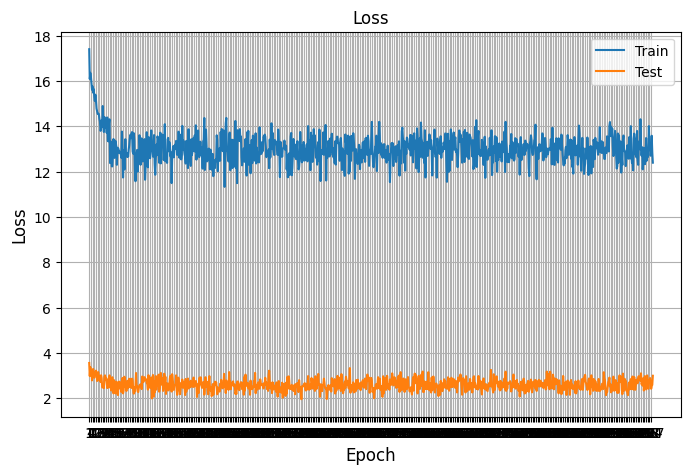

In [62]:
title = 'Loss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_losses, test_losses], [label1, label2], len(train_losses), title, xlabel, ylabel)

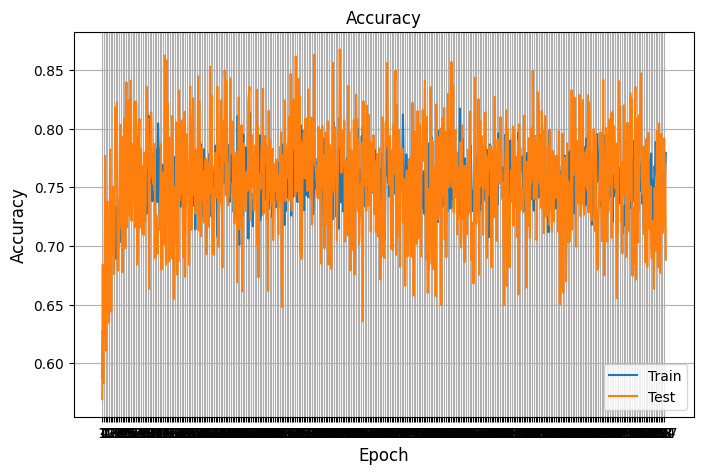

In [63]:
title = 'Accuracy'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Accuracy'
plot([train_accuracies, test_accuracies], [label1, label2], len(train_losses), title, xlabel, ylabel)

In [66]:
def train_epoch(dataloader, model_enc, model_class, loss_fn, optimizer, device, optimizer_enc=None):
    #model_enc.train()
    #freeze_encoder(model_enc)
    model_class.train()
    for idx, (x, label) in enumerate(dataloader):
        optimizer.zero_grad()
        if optimizer_enc is not None:
            optimizer_enc.zero_grad()
        
        x, label = x.to(device), label.to(device)
        feture_map, y = model_enc(x)
        
        outputs = model_class(y.squeeze())
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()
        if optimizer_enc is not None:
            optimizer_enc.step()
    
def evaluate(dataloader, model_enc, model_class, loss_fn, device):
    model_enc.eval()
    model_class.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, (x, label) in enumerate(dataloader):
            x, label = x.to(device), label.to(device)
            feture_map, y = model_enc(x)
            
            outputs = model_class(y.squeeze())
            total_loss += float(loss_fn(outputs, label).detach())
            _, predicted = torch.max(outputs.data, 1)

            total_accuracy += predicted.eq(label.data).cpu().sum()
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model_enc, model_class, loss_fn, optimizer, 
    device, num_epochs, scheduler=None, optimizer_enc=None
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in tqdm(range(num_epochs)):
        train_epoch(train_loader, model_enc, model_class, loss_fn, optimizer, device, optimizer_enc)
        
        train_loss, train_acc = evaluate(train_loader, model_enc, model_class, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model_enc, model_class, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        if scheduler is not None:
            scheduler.step()
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

In [96]:
#resnet = ResNet18(width=2).to(device)
resnet.eval()
class_nn = Classifier_NN(128).to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer_class = torch.optim.Adam(class_nn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_class, step_size=50, gamma=0.5)

In [77]:
device

device(type='cuda', index=0)

In [95]:
next(resnet.parameters()).device

device(type='cuda', index=0)

In [97]:
#resnet.load_state_dict(torch.load('resnet_subseq_lr.pt'))#.to(device)
resnet.load_state_dict(torch.load('model_enc_last_test.pt'))#.to(device)
#resnet.eval()
resnet.train()
optimizer_enc = torch.optim.Adam(resnet.parameters(), lr=1e-4)

In [101]:
def freeze_encoder(model):
    for name, param in model.named_parameters():
        # if name[:6] == 'layer4' or name[:2] == 'fc' or name[:6] == 'layer3':
        #     param.requires_grad = True
        # else:
            param.requires_grad = False

In [92]:
freeze_encoder(resnet)

In [102]:
for name, param in resnet.named_parameters():
    print(name, param.requires_grad)

conv1.0.weight True
conv1.2.weight True
conv1.2.bias True
layer1.0.left.0.weight True
layer1.0.left.1.weight True
layer1.0.left.1.bias True
layer1.0.left.4.weight True
layer1.0.left.5.weight True
layer1.0.left.5.bias True
layer1.1.left.0.weight True
layer1.1.left.1.weight True
layer1.1.left.1.bias True
layer1.1.left.4.weight True
layer1.1.left.5.weight True
layer1.1.left.5.bias True
layer2.0.left.0.weight True
layer2.0.left.1.weight True
layer2.0.left.1.bias True
layer2.0.left.4.weight True
layer2.0.left.5.weight True
layer2.0.left.5.bias True
layer2.0.shortcut.0.weight True
layer2.0.shortcut.2.weight True
layer2.0.shortcut.2.bias True
layer2.1.left.0.weight True
layer2.1.left.1.weight True
layer2.1.left.1.bias True
layer2.1.left.4.weight True
layer2.1.left.5.weight True
layer2.1.left.5.bias True
layer3.0.left.0.weight True
layer3.0.left.1.weight True
layer3.0.left.1.bias True
layer3.0.left.4.weight True
layer3.0.left.5.weight True
layer3.0.left.5.bias True
layer3.0.shortcut.0.weight T

All resnet train - 0.603/4, 0.673/23, 0.680/56

From scratch - 0.604/3, 0.651/98, 0.662/193

Only 4 layer - 0.404/5, 0.454/13

3+4 layer - 0.505/4, 0.550/122



subseq_last - 0.590/90
subseq_best - 0.529/150

subseq_last_lr_20/0.5 - 0.458/130
subseq_last_lr_50/0.5 - 0.469/145
subseq_best_lr_50/0.5 - 0.471/159

subseq_best_lr_50/0.5 all resnet train - 0.630/25

patches best without mse - 0.636/23
patches best with mse - 0.610/56, 0.650/990

patches stride < patch_size with mse - 0.606/38 0.648/985
patches stride < patch_size without mse - 0.641/33 0.646/410

patches new, mse, stride=patch: fine-tuning - 0.626/46, transfer ~ 0.3
patches new, mse, stride=patch: fine-tuning - 0.517/7, 0.606/33, transfer - 0.598/29


cat patches transfer - 0.590/22, fine-tuning ~ 0.6

cosine transfer - 0.584/25, fine-tuning 0.594/16
cosine bce transfer - 0.32/125, fine-tuning 0.594/16
cosine bce transfer 1 loss (best) - 0.324/25, fine-tuning 0.576/26
cosine bce transfer 1 loss (last) - 0.343/24, fine-tuning 0.577/22

In [5]:
tabledata = [
         ["InfoMax all fine-tuning", '0.603/4', '0.673/23', '0.680/56'],
         ["InfoMax fine-tuning only 4 layer", '0.404/5', '0.454/13', 'Same'],
         ["InfoMax From scratch ", '0.604/3', '0.651/98', '0.662/193'],
         ["SubSeq from last epoch, transfer", '0.590/90', 'Same', 'Same'],
         ["SubSeq best accuracy, transfer", '0.529/150', 'Same', 'Same'],
         ["SubSeq last, fine-tuning", '0.636/23', 'Same', 'Same'],
         ["SubSeq last, stride < patch_size, fine-tuning", '0.641/33', '0.646/410', 'Same'],
         ["SubSeq last, + mse_loss, fine-tuning", '0.610/56', '0.650/990', 'Same'],
         ["SubSeq last, stride < patch_size, + mse_loss, fine-tuning", '0.606/38', '0.648/985', 'Same'],
         ["SubSeq last, + mse_loss, + patch-patch loss fine-tuning", '0.626/46', 'Same', 'Same'],
         ["SubSeq last, + mse_loss, + patch-patch loss transfer", '~0.4/~50 ', 'Same', 'Same'],
         ["SubSeq last cat patches, + mse_loss, + patch-patch loss fine-tuning", '0.635/36', 'Same', 'Same'],
         ["SubSeq last cat patches, + mse_loss, + patch-patch loss transfer", '0.490/22', 'Same', 'Same'],
         ["SubSeq last cat patches, cosine MI, fine-tuning", '0.594/16', 'Same', 'Same'],
         ["SubSeq last cat patches, cosine MI, transfer", '0.484/25', 'Same', 'Same'],
         ["SubSeq last cat patches, cosine MI + bce, fine-tuning", '0.577/22', 'Same', 'Same'],
         ["SubSeq last cat patches, cosine MI + bce, transfer", '0.343/24', 'Same', 'Same'],
    ]

In [7]:
from tabulate import tabulate 
print(tabulate(tabledata))

-------------------------------------------------------------------  ---------  ---------  ---------
InfoMax all fine-tuning                                              0.603/4    0.673/23   0.680/56
InfoMax fine-tuning only 4 layer                                     0.404/5    0.454/13   Same
InfoMax From scratch                                                 0.604/3    0.651/98   0.662/193
SubSeq from last epoch, transfer                                     0.590/90   Same       Same
SubSeq best accuracy, transfer                                       0.529/150  Same       Same
SubSeq last, fine-tuning                                             0.636/23   Same       Same
SubSeq last, stride < patch_size, fine-tuning                        0.641/33   0.646/410  Same
SubSeq last, + mse_loss, fine-tuning                                 0.610/56   0.650/990  Same
SubSeq last, stride < patch_size, + mse_loss, fine-tuning            0.606/38   0.648/985  Same
SubSeq last, + mse_loss, +

In [8]:
from IPython.display import HTML, display
display(HTML(tabulate(tabledata, headers=["Type", "Accuracy / Epoch", "Accuracy / Epoch", "Accuracy / Epoch"], tablefmt='html')))
print('"stride < patch_size" means that different patches may intersect')
print('"Same" means that accuracy then didn\'t change')

Type,Accuracy / Epoch,Accuracy / Epoch,Accuracy / Epoch
InfoMax all fine-tuning,0.603/4,0.673/23,0.680/56
InfoMax fine-tuning only 4 layer,0.404/5,0.454/13,Same
InfoMax From scratch,0.604/3,0.651/98,0.662/193
"SubSeq from last epoch, transfer",0.590/90,Same,Same
"SubSeq best accuracy, transfer",0.529/150,Same,Same
"SubSeq last, fine-tuning",0.636/23,Same,Same
"SubSeq last, stride < patch_size, fine-tuning",0.641/33,0.646/410,Same
"SubSeq last, + mse_loss, fine-tuning",0.610/56,0.650/990,Same
"SubSeq last, stride < patch_size, + mse_loss, fine-tuning",0.606/38,0.648/985,Same
"SubSeq last, + mse_loss, + patch-patch loss fine-tuning",0.626/46,Same,Same


"stride < patch_size" means that different patches may intersect
"Same" means that accuracy then didn't change


In [35]:
tabledata_ft = [
         ["SubSeq, fine-tuning", '0.636', '0.594'],
         ["SubSeq, + pos loss, fine-tuning", '0.650', '-'],
         ["SubSeq, + pos loss, + patch-patch loss, fine-tuning", '0.635', '-'],
         ["InfoMax all fine-tuning", '0.680', '0.594'],
    ]

tabledata_trans = [
         ["SubSeq, transfer", '0.590', '0.484'],
         ["SubSeq, + pos loss, transfer", '0.598', '-', 'Same'],
         ["SubSeq, + pos loss, + patch-patch loss, transfer", '~0.4', '-'],
         ["InfoMax freeze all layers exept the last", '0.454', '0.484'],
    ]

In [33]:
display(HTML(tabulate(tabledata_ft, headers=["Type", "Accuracy / MI: NN", "Accuracy / MI: cosine"], tablefmt='html')))

Type,Accuracy / MI: NN,Accuracy / MI: cosine
"SubSeq, fine-tuning",0.636,0.594
"SubSeq, + pos loss, fine-tuning",0.65,-
"SubSeq, + pos loss, + patch-patch loss, fine-tuning",0.635,-
InfoMax all fine-tuning,0.68,0.594


In [36]:
display(HTML(tabulate(tabledata_trans, headers=["Type", "Accuracy / MI: NN", "Accuracy / MI: cosine"], tablefmt='html')))

Type,Accuracy / MI: NN,Accuracy / MI: cosine
"SubSeq, transfer",0.590,0.484
"SubSeq, + pos loss, transfer",0.598,-
"SubSeq, + pos loss, + patch-patch loss, transfer",~0.4,-
InfoMax freeze all layers exept the last,0.454,0.484


In [20]:
display(HTML(tabulate(tabledata_trans[:-2], headers=["Type", "Accuracy / Epoch", "Accuracy / Epoch", "Accuracy / Epoch"], tablefmt='html')))

Type,Accuracy / Epoch,Accuracy / Epoch,Accuracy / Epoch
"SubSeq from last epoch, transfer",0.590/90,Same,Same
"SubSeq best accuracy, transfer",0.529/150,Same,Same
"SubSeq last, + mse_loss, + patch-patch loss, transfer",~0.4/~50,Same,Same
"SubSeq last cat patches, + mse_loss, + patch-patch loss, transfer",0.490/22,Same,Same


In [21]:
display(HTML(tabulate(tabledata_trans[-2:], headers=["Type", "Accuracy / Epoch", "Accuracy / Epoch", "Accuracy / Epoch"], tablefmt='html')))

Type,Accuracy / Epoch,Accuracy / Epoch,Accuracy / Epoch
"SubSeq last cat patches, cosine MI, transfer",0.484/25,Same,Same
"SubSeq last cat patches, cosine MI + bce, transfer",0.343/24,Same,Same


In [109]:
import pandas as pd

In [112]:
pd.DataFrame({'d':[], 'g':[]})

,d,g


In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = \
      train(train_loader, test_loader, resnet, class_nn, criterion, 
            optimizer_class, device, num_epochs=1000, scheduler=scheduler, optimizer_enc=optimizer_enc)

  0%|          | 1/1000 [00:19<5:17:27, 19.07s/it]

Epoch: 1/1000. Loss (Train/Test): 2.017/2.012. Accuracy (Train/Test): 0.257/0.260


  0%|          | 2/1000 [00:38<5:16:35, 19.03s/it]

Epoch: 2/1000. Loss (Train/Test): 1.724/1.720. Accuracy (Train/Test): 0.365/0.367


  0%|          | 3/1000 [00:57<5:16:27, 19.04s/it]

Epoch: 3/1000. Loss (Train/Test): 1.537/1.541. Accuracy (Train/Test): 0.438/0.440


  0%|          | 4/1000 [01:16<5:16:15, 19.05s/it]

Epoch: 4/1000. Loss (Train/Test): 1.432/1.456. Accuracy (Train/Test): 0.476/0.467


  0%|          | 5/1000 [01:35<5:15:10, 19.01s/it]

Epoch: 5/1000. Loss (Train/Test): 1.360/1.396. Accuracy (Train/Test): 0.506/0.486


  1%|          | 6/1000 [01:54<5:18:08, 19.20s/it]

Epoch: 6/1000. Loss (Train/Test): 1.300/1.359. Accuracy (Train/Test): 0.531/0.505


  1%|          | 7/1000 [02:14<5:18:39, 19.25s/it]

Epoch: 7/1000. Loss (Train/Test): 1.341/1.413. Accuracy (Train/Test): 0.521/0.497


  1%|          | 8/1000 [02:33<5:17:07, 19.18s/it]

Epoch: 8/1000. Loss (Train/Test): 1.220/1.319. Accuracy (Train/Test): 0.562/0.517


  1%|          | 9/1000 [02:52<5:16:55, 19.19s/it]

Epoch: 9/1000. Loss (Train/Test): 1.168/1.290. Accuracy (Train/Test): 0.579/0.531


  1%|          | 10/1000 [03:11<5:15:13, 19.10s/it]

Epoch: 10/1000. Loss (Train/Test): 1.132/1.276. Accuracy (Train/Test): 0.592/0.532


  1%|          | 11/1000 [03:30<5:15:29, 19.14s/it]

Epoch: 11/1000. Loss (Train/Test): 1.104/1.272. Accuracy (Train/Test): 0.606/0.545


  1%|          | 12/1000 [03:49<5:14:57, 19.13s/it]

Epoch: 12/1000. Loss (Train/Test): 1.069/1.274. Accuracy (Train/Test): 0.621/0.546


  1%|▏         | 13/1000 [04:08<5:13:29, 19.06s/it]

Epoch: 13/1000. Loss (Train/Test): 1.011/1.235. Accuracy (Train/Test): 0.640/0.555


  1%|▏         | 14/1000 [04:27<5:13:46, 19.09s/it]

Epoch: 14/1000. Loss (Train/Test): 1.022/1.280. Accuracy (Train/Test): 0.635/0.545


  2%|▏         | 15/1000 [04:46<5:11:33, 18.98s/it]

Epoch: 15/1000. Loss (Train/Test): 0.956/1.251. Accuracy (Train/Test): 0.660/0.557


  2%|▏         | 16/1000 [05:05<5:12:19, 19.04s/it]

Epoch: 16/1000. Loss (Train/Test): 0.918/1.244. Accuracy (Train/Test): 0.674/0.563


  2%|▏         | 17/1000 [05:24<5:10:23, 18.95s/it]

Epoch: 17/1000. Loss (Train/Test): 0.874/1.235. Accuracy (Train/Test): 0.693/0.566


  2%|▏         | 18/1000 [05:43<5:10:29, 18.97s/it]

Epoch: 18/1000. Loss (Train/Test): 0.845/1.243. Accuracy (Train/Test): 0.702/0.566


  2%|▏         | 19/1000 [06:02<5:10:44, 19.01s/it]

Epoch: 19/1000. Loss (Train/Test): 0.803/1.247. Accuracy (Train/Test): 0.720/0.571


  2%|▏         | 20/1000 [06:21<5:10:28, 19.01s/it]

Epoch: 20/1000. Loss (Train/Test): 0.825/1.312. Accuracy (Train/Test): 0.709/0.550


  2%|▏         | 21/1000 [06:40<5:09:12, 18.95s/it]

Epoch: 21/1000. Loss (Train/Test): 0.796/1.328. Accuracy (Train/Test): 0.718/0.559


  2%|▏         | 22/1000 [06:59<5:09:24, 18.98s/it]

Epoch: 22/1000. Loss (Train/Test): 0.691/1.266. Accuracy (Train/Test): 0.765/0.577


  2%|▏         | 23/1000 [07:18<5:08:46, 18.96s/it]

Epoch: 23/1000. Loss (Train/Test): 0.665/1.292. Accuracy (Train/Test): 0.773/0.572


  2%|▏         | 24/1000 [07:37<5:08:45, 18.98s/it]

Epoch: 24/1000. Loss (Train/Test): 0.670/1.336. Accuracy (Train/Test): 0.767/0.568


  2%|▎         | 25/1000 [07:56<5:08:25, 18.98s/it]

Epoch: 25/1000. Loss (Train/Test): 0.595/1.325. Accuracy (Train/Test): 0.799/0.572


  3%|▎         | 26/1000 [08:15<5:08:12, 18.99s/it]

Epoch: 26/1000. Loss (Train/Test): 0.569/1.372. Accuracy (Train/Test): 0.808/0.565


  3%|▎         | 27/1000 [08:34<5:10:51, 19.17s/it]

Epoch: 27/1000. Loss (Train/Test): 0.530/1.400. Accuracy (Train/Test): 0.822/0.571


  3%|▎         | 28/1000 [08:54<5:11:03, 19.20s/it]

Epoch: 28/1000. Loss (Train/Test): 0.506/1.423. Accuracy (Train/Test): 0.832/0.568


  3%|▎         | 29/1000 [09:13<5:10:30, 19.19s/it]

Epoch: 29/1000. Loss (Train/Test): 0.456/1.439. Accuracy (Train/Test): 0.852/0.569


  3%|▎         | 30/1000 [09:31<5:08:15, 19.07s/it]

Epoch: 30/1000. Loss (Train/Test): 0.431/1.495. Accuracy (Train/Test): 0.861/0.570


  3%|▎         | 31/1000 [09:51<5:07:47, 19.06s/it]

Epoch: 31/1000. Loss (Train/Test): 0.427/1.566. Accuracy (Train/Test): 0.860/0.563


  3%|▎         | 32/1000 [10:10<5:07:38, 19.07s/it]

Epoch: 32/1000. Loss (Train/Test): 0.385/1.589. Accuracy (Train/Test): 0.876/0.564


  3%|▎         | 33/1000 [10:29<5:10:30, 19.27s/it]

Epoch: 33/1000. Loss (Train/Test): 0.324/1.625. Accuracy (Train/Test): 0.902/0.570


  3%|▎         | 34/1000 [10:48<5:09:11, 19.20s/it]

Epoch: 34/1000. Loss (Train/Test): 0.301/1.676. Accuracy (Train/Test): 0.913/0.562


  4%|▎         | 35/1000 [11:08<5:08:33, 19.18s/it]

Epoch: 35/1000. Loss (Train/Test): 0.293/1.774. Accuracy (Train/Test): 0.910/0.556


  4%|▎         | 36/1000 [11:27<5:08:16, 19.19s/it]

Epoch: 36/1000. Loss (Train/Test): 0.266/1.831. Accuracy (Train/Test): 0.920/0.559


  4%|▎         | 37/1000 [11:46<5:06:19, 19.09s/it]

Epoch: 37/1000. Loss (Train/Test): 0.271/1.919. Accuracy (Train/Test): 0.913/0.557


  4%|▍         | 38/1000 [12:05<5:06:44, 19.13s/it]

Epoch: 38/1000. Loss (Train/Test): 0.198/1.919. Accuracy (Train/Test): 0.949/0.559


  4%|▍         | 39/1000 [12:24<5:05:57, 19.10s/it]

Epoch: 39/1000. Loss (Train/Test): 0.190/2.005. Accuracy (Train/Test): 0.950/0.559


  4%|▍         | 40/1000 [12:43<5:06:10, 19.14s/it]

Epoch: 40/1000. Loss (Train/Test): 0.150/2.051. Accuracy (Train/Test): 0.966/0.563


  4%|▍         | 41/1000 [13:02<5:05:15, 19.10s/it]

Epoch: 41/1000. Loss (Train/Test): 0.142/2.164. Accuracy (Train/Test): 0.964/0.557


  4%|▍         | 42/1000 [13:21<5:04:22, 19.06s/it]

Epoch: 42/1000. Loss (Train/Test): 0.123/2.204. Accuracy (Train/Test): 0.974/0.557


  4%|▍         | 43/1000 [13:40<5:03:47, 19.05s/it]

Epoch: 43/1000. Loss (Train/Test): 0.111/2.339. Accuracy (Train/Test): 0.974/0.556


  4%|▍         | 44/1000 [13:59<5:03:25, 19.04s/it]

Epoch: 44/1000. Loss (Train/Test): 0.087/2.425. Accuracy (Train/Test): 0.983/0.558


  4%|▍         | 45/1000 [14:18<5:03:18, 19.06s/it]

Epoch: 45/1000. Loss (Train/Test): 0.071/2.498. Accuracy (Train/Test): 0.990/0.558


  5%|▍         | 46/1000 [14:37<5:01:32, 18.96s/it]

Epoch: 46/1000. Loss (Train/Test): 0.064/2.590. Accuracy (Train/Test): 0.989/0.559


  5%|▍         | 47/1000 [14:56<5:01:06, 18.96s/it]

Epoch: 47/1000. Loss (Train/Test): 0.050/2.656. Accuracy (Train/Test): 0.994/0.560


  5%|▍         | 48/1000 [15:15<5:00:04, 18.91s/it]

Epoch: 48/1000. Loss (Train/Test): 0.038/2.770. Accuracy (Train/Test): 0.998/0.555


  5%|▍         | 49/1000 [15:34<5:00:50, 18.98s/it]

Epoch: 49/1000. Loss (Train/Test): 0.036/2.843. Accuracy (Train/Test): 0.997/0.559


  5%|▌         | 50/1000 [15:53<5:01:03, 19.01s/it]

Epoch: 50/1000. Loss (Train/Test): 0.027/2.915. Accuracy (Train/Test): 0.999/0.560


  5%|▌         | 51/1000 [16:12<5:01:41, 19.07s/it]

Epoch: 51/1000. Loss (Train/Test): 0.023/2.980. Accuracy (Train/Test): 1.000/0.558


  5%|▌         | 52/1000 [16:32<5:03:10, 19.19s/it]

Epoch: 52/1000. Loss (Train/Test): 0.018/3.058. Accuracy (Train/Test): 1.000/0.556


  5%|▌         | 53/1000 [16:51<5:03:14, 19.21s/it]

Epoch: 53/1000. Loss (Train/Test): 0.014/3.111. Accuracy (Train/Test): 1.000/0.561


  5%|▌         | 54/1000 [17:10<5:03:59, 19.28s/it]

Epoch: 54/1000. Loss (Train/Test): 0.012/3.168. Accuracy (Train/Test): 1.000/0.559


  6%|▌         | 55/1000 [17:30<5:04:52, 19.36s/it]

Epoch: 55/1000. Loss (Train/Test): 0.011/3.230. Accuracy (Train/Test): 1.000/0.558


  6%|▌         | 56/1000 [17:49<5:03:24, 19.28s/it]

Epoch: 56/1000. Loss (Train/Test): 0.009/3.281. Accuracy (Train/Test): 1.000/0.561


  6%|▌         | 57/1000 [18:09<5:04:34, 19.38s/it]

Epoch: 57/1000. Loss (Train/Test): 0.008/3.329. Accuracy (Train/Test): 1.000/0.559


  6%|▌         | 58/1000 [18:28<5:03:51, 19.35s/it]

Epoch: 58/1000. Loss (Train/Test): 0.008/3.371. Accuracy (Train/Test): 1.000/0.562


  6%|▌         | 59/1000 [18:47<5:02:55, 19.31s/it]

Epoch: 59/1000. Loss (Train/Test): 0.007/3.416. Accuracy (Train/Test): 1.000/0.561


  6%|▌         | 60/1000 [19:06<5:01:47, 19.26s/it]

Epoch: 60/1000. Loss (Train/Test): 0.006/3.455. Accuracy (Train/Test): 1.000/0.561


  6%|▌         | 61/1000 [19:25<5:01:23, 19.26s/it]

Epoch: 61/1000. Loss (Train/Test): 0.006/3.500. Accuracy (Train/Test): 1.000/0.561


  6%|▌         | 62/1000 [19:44<4:59:49, 19.18s/it]

Epoch: 62/1000. Loss (Train/Test): 0.005/3.533. Accuracy (Train/Test): 1.000/0.562


  6%|▋         | 63/1000 [20:04<4:59:23, 19.17s/it]

Epoch: 63/1000. Loss (Train/Test): 0.005/3.573. Accuracy (Train/Test): 1.000/0.561


  6%|▋         | 64/1000 [20:23<4:58:29, 19.13s/it]

Epoch: 64/1000. Loss (Train/Test): 0.005/3.609. Accuracy (Train/Test): 1.000/0.560


  6%|▋         | 65/1000 [20:42<4:56:57, 19.06s/it]

Epoch: 65/1000. Loss (Train/Test): 0.004/3.640. Accuracy (Train/Test): 1.000/0.560


  7%|▋         | 66/1000 [21:01<4:58:22, 19.17s/it]

Epoch: 66/1000. Loss (Train/Test): 0.004/3.677. Accuracy (Train/Test): 1.000/0.560


  7%|▋         | 67/1000 [21:20<4:59:34, 19.27s/it]

Epoch: 67/1000. Loss (Train/Test): 0.004/3.713. Accuracy (Train/Test): 1.000/0.561


  7%|▋         | 68/1000 [21:40<5:02:20, 19.46s/it]

Epoch: 68/1000. Loss (Train/Test): 0.004/3.734. Accuracy (Train/Test): 1.000/0.561


  7%|▋         | 69/1000 [22:00<5:04:00, 19.59s/it]

Epoch: 69/1000. Loss (Train/Test): 0.003/3.772. Accuracy (Train/Test): 1.000/0.560


  7%|▋         | 70/1000 [22:20<5:02:17, 19.50s/it]

Epoch: 70/1000. Loss (Train/Test): 0.003/3.800. Accuracy (Train/Test): 1.000/0.561


  7%|▋         | 71/1000 [22:39<5:01:34, 19.48s/it]

Epoch: 71/1000. Loss (Train/Test): 0.003/3.829. Accuracy (Train/Test): 1.000/0.562


  7%|▋         | 72/1000 [22:58<4:57:17, 19.22s/it]

Epoch: 72/1000. Loss (Train/Test): 0.003/3.858. Accuracy (Train/Test): 1.000/0.559


  7%|▋         | 73/1000 [23:17<4:55:45, 19.14s/it]

Epoch: 73/1000. Loss (Train/Test): 0.003/3.888. Accuracy (Train/Test): 1.000/0.562


  7%|▋         | 74/1000 [23:35<4:54:26, 19.08s/it]

Epoch: 74/1000. Loss (Train/Test): 0.003/3.912. Accuracy (Train/Test): 1.000/0.560


  8%|▊         | 75/1000 [23:55<4:54:18, 19.09s/it]

Epoch: 75/1000. Loss (Train/Test): 0.002/3.937. Accuracy (Train/Test): 1.000/0.560


  8%|▊         | 76/1000 [24:14<4:53:34, 19.06s/it]

Epoch: 76/1000. Loss (Train/Test): 0.002/3.963. Accuracy (Train/Test): 1.000/0.561


  8%|▊         | 77/1000 [24:33<4:52:39, 19.02s/it]

Epoch: 77/1000. Loss (Train/Test): 0.002/3.992. Accuracy (Train/Test): 1.000/0.561


  8%|▊         | 78/1000 [24:51<4:51:07, 18.95s/it]

Epoch: 78/1000. Loss (Train/Test): 0.002/4.015. Accuracy (Train/Test): 1.000/0.561


  8%|▊         | 79/1000 [25:10<4:51:43, 19.01s/it]

Epoch: 79/1000. Loss (Train/Test): 0.002/4.042. Accuracy (Train/Test): 1.000/0.560


  8%|▊         | 80/1000 [25:29<4:50:55, 18.97s/it]

Epoch: 80/1000. Loss (Train/Test): 0.002/4.066. Accuracy (Train/Test): 1.000/0.560


  8%|▊         | 81/1000 [25:49<4:52:21, 19.09s/it]

Epoch: 81/1000. Loss (Train/Test): 0.002/4.089. Accuracy (Train/Test): 1.000/0.561


  8%|▊         | 82/1000 [26:08<4:52:46, 19.14s/it]

Epoch: 82/1000. Loss (Train/Test): 0.002/4.109. Accuracy (Train/Test): 1.000/0.562


  8%|▊         | 83/1000 [26:27<4:52:58, 19.17s/it]

Epoch: 83/1000. Loss (Train/Test): 0.002/4.135. Accuracy (Train/Test): 1.000/0.560


  8%|▊         | 84/1000 [26:46<4:52:03, 19.13s/it]

Epoch: 84/1000. Loss (Train/Test): 0.002/4.161. Accuracy (Train/Test): 1.000/0.559


  8%|▊         | 85/1000 [27:05<4:51:17, 19.10s/it]

Epoch: 85/1000. Loss (Train/Test): 0.001/4.182. Accuracy (Train/Test): 1.000/0.560


  9%|▊         | 86/1000 [27:24<4:50:40, 19.08s/it]

Epoch: 86/1000. Loss (Train/Test): 0.001/4.203. Accuracy (Train/Test): 1.000/0.560


  9%|▊         | 87/1000 [27:43<4:50:45, 19.11s/it]

Epoch: 87/1000. Loss (Train/Test): 0.001/4.227. Accuracy (Train/Test): 1.000/0.561


  9%|▉         | 88/1000 [28:03<4:50:47, 19.13s/it]

Epoch: 88/1000. Loss (Train/Test): 0.001/4.250. Accuracy (Train/Test): 1.000/0.560


  9%|▉         | 89/1000 [28:22<4:50:03, 19.10s/it]

Epoch: 89/1000. Loss (Train/Test): 0.001/4.266. Accuracy (Train/Test): 1.000/0.560


  9%|▉         | 90/1000 [28:41<4:48:52, 19.05s/it]

Epoch: 90/1000. Loss (Train/Test): 0.001/4.290. Accuracy (Train/Test): 1.000/0.560


  9%|▉         | 91/1000 [29:00<4:49:27, 19.11s/it]

Epoch: 91/1000. Loss (Train/Test): 0.001/4.307. Accuracy (Train/Test): 1.000/0.560


  9%|▉         | 92/1000 [29:19<4:49:00, 19.10s/it]

Epoch: 92/1000. Loss (Train/Test): 0.001/4.331. Accuracy (Train/Test): 1.000/0.561


  9%|▉         | 93/1000 [29:38<4:48:12, 19.07s/it]

Epoch: 93/1000. Loss (Train/Test): 0.001/4.351. Accuracy (Train/Test): 1.000/0.560


  9%|▉         | 94/1000 [29:57<4:47:54, 19.07s/it]

Epoch: 94/1000. Loss (Train/Test): 0.001/4.368. Accuracy (Train/Test): 1.000/0.560


 10%|▉         | 95/1000 [30:16<4:48:22, 19.12s/it]

Epoch: 95/1000. Loss (Train/Test): 0.001/4.387. Accuracy (Train/Test): 1.000/0.561


 10%|▉         | 96/1000 [30:36<4:49:22, 19.21s/it]

Epoch: 96/1000. Loss (Train/Test): 0.001/4.412. Accuracy (Train/Test): 1.000/0.560


 10%|▉         | 97/1000 [30:55<4:48:06, 19.14s/it]

Epoch: 97/1000. Loss (Train/Test): 0.001/4.426. Accuracy (Train/Test): 1.000/0.562


 10%|▉         | 98/1000 [31:14<4:48:09, 19.17s/it]

Epoch: 98/1000. Loss (Train/Test): 0.001/4.449. Accuracy (Train/Test): 1.000/0.560


 10%|▉         | 99/1000 [31:33<4:48:54, 19.24s/it]

Epoch: 99/1000. Loss (Train/Test): 0.001/4.464. Accuracy (Train/Test): 1.000/0.561


 10%|█         | 100/1000 [31:53<4:50:08, 19.34s/it]

Epoch: 100/1000. Loss (Train/Test): 0.001/4.482. Accuracy (Train/Test): 1.000/0.560


 10%|█         | 101/1000 [32:12<4:48:44, 19.27s/it]

Epoch: 101/1000. Loss (Train/Test): 0.001/4.496. Accuracy (Train/Test): 1.000/0.561


 10%|█         | 102/1000 [32:31<4:47:14, 19.19s/it]

Epoch: 102/1000. Loss (Train/Test): 0.001/4.510. Accuracy (Train/Test): 1.000/0.561


 10%|█         | 103/1000 [32:50<4:47:37, 19.24s/it]

Epoch: 103/1000. Loss (Train/Test): 0.001/4.525. Accuracy (Train/Test): 1.000/0.561


 10%|█         | 104/1000 [33:10<4:47:27, 19.25s/it]

Epoch: 104/1000. Loss (Train/Test): 0.001/4.535. Accuracy (Train/Test): 1.000/0.560


 10%|█         | 105/1000 [33:29<4:46:41, 19.22s/it]

Epoch: 105/1000. Loss (Train/Test): 0.001/4.550. Accuracy (Train/Test): 1.000/0.560


 11%|█         | 106/1000 [33:48<4:46:27, 19.23s/it]

Epoch: 106/1000. Loss (Train/Test): 0.001/4.562. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 107/1000 [34:07<4:43:34, 19.05s/it]

Epoch: 107/1000. Loss (Train/Test): 0.001/4.580. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 108/1000 [34:25<4:42:04, 18.97s/it]

Epoch: 108/1000. Loss (Train/Test): 0.001/4.591. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 109/1000 [34:44<4:41:00, 18.92s/it]

Epoch: 109/1000. Loss (Train/Test): 0.001/4.602. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 110/1000 [35:03<4:42:01, 19.01s/it]

Epoch: 110/1000. Loss (Train/Test): 0.001/4.619. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 111/1000 [35:22<4:40:54, 18.96s/it]

Epoch: 111/1000. Loss (Train/Test): 0.001/4.629. Accuracy (Train/Test): 1.000/0.561


 11%|█         | 112/1000 [35:41<4:40:38, 18.96s/it]

Epoch: 112/1000. Loss (Train/Test): 0.001/4.643. Accuracy (Train/Test): 1.000/0.561


 11%|█▏        | 113/1000 [36:00<4:40:10, 18.95s/it]

Epoch: 113/1000. Loss (Train/Test): 0.001/4.657. Accuracy (Train/Test): 1.000/0.561


 11%|█▏        | 114/1000 [36:19<4:38:40, 18.87s/it]

Epoch: 114/1000. Loss (Train/Test): 0.001/4.669. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 115/1000 [36:38<4:41:12, 19.06s/it]

Epoch: 115/1000. Loss (Train/Test): 0.001/4.680. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 116/1000 [36:57<4:40:35, 19.04s/it]

Epoch: 116/1000. Loss (Train/Test): 0.001/4.693. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 117/1000 [37:16<4:38:53, 18.95s/it]

Epoch: 117/1000. Loss (Train/Test): 0.001/4.705. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 118/1000 [37:35<4:37:17, 18.86s/it]

Epoch: 118/1000. Loss (Train/Test): 0.000/4.717. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 119/1000 [37:54<4:37:19, 18.89s/it]

Epoch: 119/1000. Loss (Train/Test): 0.000/4.731. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 120/1000 [38:13<4:36:43, 18.87s/it]

Epoch: 120/1000. Loss (Train/Test): 0.000/4.744. Accuracy (Train/Test): 1.000/0.560


 12%|█▏        | 121/1000 [38:32<4:37:26, 18.94s/it]

Epoch: 121/1000. Loss (Train/Test): 0.000/4.753. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 122/1000 [38:51<4:39:30, 19.10s/it]

Epoch: 122/1000. Loss (Train/Test): 0.000/4.766. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 123/1000 [39:11<4:41:38, 19.27s/it]

Epoch: 123/1000. Loss (Train/Test): 0.000/4.780. Accuracy (Train/Test): 1.000/0.561


 12%|█▏        | 124/1000 [39:30<4:40:16, 19.20s/it]

Epoch: 124/1000. Loss (Train/Test): 0.000/4.793. Accuracy (Train/Test): 1.000/0.561


 12%|█▎        | 125/1000 [39:49<4:39:49, 19.19s/it]

Epoch: 125/1000. Loss (Train/Test): 0.000/4.802. Accuracy (Train/Test): 1.000/0.560


 13%|█▎        | 126/1000 [40:08<4:38:44, 19.14s/it]

Epoch: 126/1000. Loss (Train/Test): 0.000/4.814. Accuracy (Train/Test): 1.000/0.562


 13%|█▎        | 127/1000 [40:27<4:38:50, 19.16s/it]

Epoch: 127/1000. Loss (Train/Test): 0.000/4.826. Accuracy (Train/Test): 1.000/0.562


 13%|█▎        | 128/1000 [40:46<4:38:15, 19.15s/it]

Epoch: 128/1000. Loss (Train/Test): 0.000/4.838. Accuracy (Train/Test): 1.000/0.562


 13%|█▎        | 129/1000 [41:05<4:37:16, 19.10s/it]

Epoch: 129/1000. Loss (Train/Test): 0.000/4.848. Accuracy (Train/Test): 1.000/0.562


 13%|█▎        | 130/1000 [41:25<4:38:52, 19.23s/it]

Epoch: 130/1000. Loss (Train/Test): 0.000/4.862. Accuracy (Train/Test): 1.000/0.561


 13%|█▎        | 131/1000 [41:44<4:38:43, 19.24s/it]

Epoch: 131/1000. Loss (Train/Test): 0.000/4.872. Accuracy (Train/Test): 1.000/0.561


 13%|█▎        | 132/1000 [42:03<4:36:56, 19.14s/it]

Epoch: 132/1000. Loss (Train/Test): 0.000/4.883. Accuracy (Train/Test): 1.000/0.561


 13%|█▎        | 133/1000 [42:22<4:35:34, 19.07s/it]

Epoch: 133/1000. Loss (Train/Test): 0.000/4.894. Accuracy (Train/Test): 1.000/0.561


 13%|█▎        | 134/1000 [42:41<4:35:10, 19.07s/it]

Epoch: 134/1000. Loss (Train/Test): 0.000/4.907. Accuracy (Train/Test): 1.000/0.561


 14%|█▎        | 135/1000 [43:00<4:33:51, 19.00s/it]

Epoch: 135/1000. Loss (Train/Test): 0.000/4.916. Accuracy (Train/Test): 1.000/0.562


 14%|█▎        | 136/1000 [43:19<4:34:31, 19.06s/it]

Epoch: 136/1000. Loss (Train/Test): 0.000/4.929. Accuracy (Train/Test): 1.000/0.561


 14%|█▎        | 137/1000 [43:38<4:33:35, 19.02s/it]

Epoch: 137/1000. Loss (Train/Test): 0.000/4.940. Accuracy (Train/Test): 1.000/0.562


 14%|█▍        | 138/1000 [43:57<4:33:54, 19.07s/it]

Epoch: 138/1000. Loss (Train/Test): 0.000/4.951. Accuracy (Train/Test): 1.000/0.561


 14%|█▍        | 139/1000 [44:16<4:33:02, 19.03s/it]

Epoch: 139/1000. Loss (Train/Test): 0.000/4.960. Accuracy (Train/Test): 1.000/0.562


 14%|█▍        | 140/1000 [44:35<4:32:32, 19.01s/it]

Epoch: 140/1000. Loss (Train/Test): 0.000/4.972. Accuracy (Train/Test): 1.000/0.563


 14%|█▍        | 141/1000 [44:54<4:32:35, 19.04s/it]

Epoch: 141/1000. Loss (Train/Test): 0.000/4.982. Accuracy (Train/Test): 1.000/0.561


 14%|█▍        | 142/1000 [45:13<4:32:19, 19.04s/it]

Epoch: 142/1000. Loss (Train/Test): 0.000/4.993. Accuracy (Train/Test): 1.000/0.562


 14%|█▍        | 143/1000 [45:32<4:32:51, 19.10s/it]

Epoch: 143/1000. Loss (Train/Test): 0.000/5.006. Accuracy (Train/Test): 1.000/0.562


 14%|█▍        | 144/1000 [45:51<4:31:41, 19.04s/it]

Epoch: 144/1000. Loss (Train/Test): 0.000/5.015. Accuracy (Train/Test): 1.000/0.561


 14%|█▍        | 145/1000 [46:11<4:32:04, 19.09s/it]

Epoch: 145/1000. Loss (Train/Test): 0.000/5.027. Accuracy (Train/Test): 1.000/0.562


 15%|█▍        | 146/1000 [46:30<4:31:55, 19.10s/it]

Epoch: 146/1000. Loss (Train/Test): 0.000/5.037. Accuracy (Train/Test): 1.000/0.561


 15%|█▍        | 147/1000 [46:49<4:32:36, 19.18s/it]

Epoch: 147/1000. Loss (Train/Test): 0.000/5.047. Accuracy (Train/Test): 1.000/0.562


 15%|█▍        | 148/1000 [47:08<4:32:53, 19.22s/it]

Epoch: 148/1000. Loss (Train/Test): 0.000/5.057. Accuracy (Train/Test): 1.000/0.562


 15%|█▍        | 149/1000 [47:27<4:31:49, 19.17s/it]

Epoch: 149/1000. Loss (Train/Test): 0.000/5.069. Accuracy (Train/Test): 1.000/0.562


 15%|█▌        | 150/1000 [47:47<4:31:44, 19.18s/it]

Epoch: 150/1000. Loss (Train/Test): 0.000/5.080. Accuracy (Train/Test): 1.000/0.562


 15%|█▌        | 151/1000 [48:06<4:31:26, 19.18s/it]

Epoch: 151/1000. Loss (Train/Test): 0.000/5.087. Accuracy (Train/Test): 1.000/0.562


 15%|█▌        | 152/1000 [48:25<4:31:04, 19.18s/it]

Epoch: 152/1000. Loss (Train/Test): 0.000/5.099. Accuracy (Train/Test): 1.000/0.561


 15%|█▌        | 153/1000 [48:44<4:30:01, 19.13s/it]

Epoch: 153/1000. Loss (Train/Test): 0.000/5.106. Accuracy (Train/Test): 1.000/0.562


 15%|█▌        | 154/1000 [49:03<4:31:06, 19.23s/it]

Epoch: 154/1000. Loss (Train/Test): 0.000/5.113. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 155/1000 [49:23<4:31:21, 19.27s/it]

Epoch: 155/1000. Loss (Train/Test): 0.000/5.124. Accuracy (Train/Test): 1.000/0.561


 16%|█▌        | 156/1000 [49:42<4:30:07, 19.20s/it]

Epoch: 156/1000. Loss (Train/Test): 0.000/5.133. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 157/1000 [50:01<4:29:32, 19.18s/it]

Epoch: 157/1000. Loss (Train/Test): 0.000/5.142. Accuracy (Train/Test): 1.000/0.561


 16%|█▌        | 158/1000 [50:20<4:28:47, 19.15s/it]

Epoch: 158/1000. Loss (Train/Test): 0.000/5.151. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 159/1000 [50:39<4:29:12, 19.21s/it]

Epoch: 159/1000. Loss (Train/Test): 0.000/5.161. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 160/1000 [50:59<4:30:58, 19.36s/it]

Epoch: 160/1000. Loss (Train/Test): 0.000/5.167. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 161/1000 [51:18<4:30:08, 19.32s/it]

Epoch: 161/1000. Loss (Train/Test): 0.000/5.179. Accuracy (Train/Test): 1.000/0.562


 16%|█▌        | 162/1000 [51:38<4:30:40, 19.38s/it]

Epoch: 162/1000. Loss (Train/Test): 0.000/5.183. Accuracy (Train/Test): 1.000/0.562


 16%|█▋        | 163/1000 [51:58<4:31:37, 19.47s/it]

Epoch: 163/1000. Loss (Train/Test): 0.000/5.195. Accuracy (Train/Test): 1.000/0.562


 16%|█▋        | 164/1000 [52:17<4:30:59, 19.45s/it]

Epoch: 164/1000. Loss (Train/Test): 0.000/5.203. Accuracy (Train/Test): 1.000/0.562


 16%|█▋        | 165/1000 [52:37<4:32:47, 19.60s/it]

Epoch: 165/1000. Loss (Train/Test): 0.000/5.213. Accuracy (Train/Test): 1.000/0.561


 17%|█▋        | 166/1000 [52:56<4:31:45, 19.55s/it]

Epoch: 166/1000. Loss (Train/Test): 0.000/5.220. Accuracy (Train/Test): 1.000/0.561


 17%|█▋        | 167/1000 [53:16<4:31:31, 19.56s/it]

Epoch: 167/1000. Loss (Train/Test): 0.000/5.231. Accuracy (Train/Test): 1.000/0.562


 17%|█▋        | 168/1000 [53:35<4:30:26, 19.50s/it]

Epoch: 168/1000. Loss (Train/Test): 0.000/5.238. Accuracy (Train/Test): 1.000/0.561


 17%|█▋        | 169/1000 [53:55<4:29:18, 19.44s/it]

Epoch: 169/1000. Loss (Train/Test): 0.000/5.248. Accuracy (Train/Test): 1.000/0.562


 17%|█▋        | 170/1000 [54:14<4:27:09, 19.31s/it]

Epoch: 170/1000. Loss (Train/Test): 0.000/5.255. Accuracy (Train/Test): 1.000/0.561


 17%|█▋        | 171/1000 [54:33<4:26:28, 19.29s/it]

Epoch: 171/1000. Loss (Train/Test): 0.000/5.263. Accuracy (Train/Test): 1.000/0.562


 17%|█▋        | 172/1000 [54:52<4:25:44, 19.26s/it]

Epoch: 172/1000. Loss (Train/Test): 0.000/5.275. Accuracy (Train/Test): 1.000/0.562


 17%|█▋        | 173/1000 [55:11<4:24:02, 19.16s/it]

Epoch: 173/1000. Loss (Train/Test): 0.000/5.282. Accuracy (Train/Test): 1.000/0.562


 17%|█▋        | 174/1000 [55:30<4:22:11, 19.05s/it]

Epoch: 174/1000. Loss (Train/Test): 0.000/5.291. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 175/1000 [55:49<4:21:34, 19.02s/it]

Epoch: 175/1000. Loss (Train/Test): 0.000/5.300. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 176/1000 [56:08<4:22:00, 19.08s/it]

Epoch: 176/1000. Loss (Train/Test): 0.000/5.308. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 177/1000 [56:27<4:21:54, 19.09s/it]

Epoch: 177/1000. Loss (Train/Test): 0.000/5.316. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 178/1000 [56:46<4:21:03, 19.06s/it]

Epoch: 178/1000. Loss (Train/Test): 0.000/5.325. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 179/1000 [57:05<4:19:47, 18.99s/it]

Epoch: 179/1000. Loss (Train/Test): 0.000/5.333. Accuracy (Train/Test): 1.000/0.561


 18%|█▊        | 180/1000 [57:24<4:19:49, 19.01s/it]

Epoch: 180/1000. Loss (Train/Test): 0.000/5.341. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 181/1000 [57:43<4:20:26, 19.08s/it]

Epoch: 181/1000. Loss (Train/Test): 0.000/5.348. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 182/1000 [58:02<4:20:23, 19.10s/it]

Epoch: 182/1000. Loss (Train/Test): 0.000/5.358. Accuracy (Train/Test): 1.000/0.563


 18%|█▊        | 183/1000 [58:22<4:20:46, 19.15s/it]

Epoch: 183/1000. Loss (Train/Test): 0.000/5.366. Accuracy (Train/Test): 1.000/0.562


 18%|█▊        | 184/1000 [58:41<4:20:06, 19.13s/it]

Epoch: 184/1000. Loss (Train/Test): 0.000/5.375. Accuracy (Train/Test): 1.000/0.563


 18%|█▊        | 185/1000 [59:00<4:20:44, 19.20s/it]

Epoch: 185/1000. Loss (Train/Test): 0.000/5.384. Accuracy (Train/Test): 1.000/0.562


 19%|█▊        | 186/1000 [59:19<4:19:53, 19.16s/it]

Epoch: 186/1000. Loss (Train/Test): 0.000/5.392. Accuracy (Train/Test): 1.000/0.562


 19%|█▊        | 187/1000 [59:38<4:19:47, 19.17s/it]

Epoch: 187/1000. Loss (Train/Test): 0.000/5.400. Accuracy (Train/Test): 1.000/0.563


 19%|█▉        | 188/1000 [59:57<4:19:24, 19.17s/it]

Epoch: 188/1000. Loss (Train/Test): 0.000/5.408. Accuracy (Train/Test): 1.000/0.562


 19%|█▉        | 189/1000 [1:00:16<4:18:03, 19.09s/it]

Epoch: 189/1000. Loss (Train/Test): 0.000/5.418. Accuracy (Train/Test): 1.000/0.562


 19%|█▉        | 190/1000 [1:00:35<4:17:49, 19.10s/it]

Epoch: 190/1000. Loss (Train/Test): 0.000/5.426. Accuracy (Train/Test): 1.000/0.561


 19%|█▉        | 191/1000 [1:00:55<4:17:40, 19.11s/it]

Epoch: 191/1000. Loss (Train/Test): 0.000/5.434. Accuracy (Train/Test): 1.000/0.562


 19%|█▉        | 192/1000 [1:01:14<4:16:53, 19.08s/it]

Epoch: 192/1000. Loss (Train/Test): 0.000/5.442. Accuracy (Train/Test): 1.000/0.562


 19%|█▉        | 193/1000 [1:01:32<4:15:31, 19.00s/it]

Epoch: 193/1000. Loss (Train/Test): 0.000/5.448. Accuracy (Train/Test): 1.000/0.562


 19%|█▉        | 194/1000 [1:01:52<4:16:01, 19.06s/it]

Epoch: 194/1000. Loss (Train/Test): 0.000/5.459. Accuracy (Train/Test): 1.000/0.563


 20%|█▉        | 195/1000 [1:02:11<4:16:01, 19.08s/it]

Epoch: 195/1000. Loss (Train/Test): 0.000/5.466. Accuracy (Train/Test): 1.000/0.562


 20%|█▉        | 196/1000 [1:02:30<4:16:56, 19.17s/it]

Epoch: 196/1000. Loss (Train/Test): 0.000/5.477. Accuracy (Train/Test): 1.000/0.562


 20%|█▉        | 197/1000 [1:02:49<4:16:41, 19.18s/it]

Epoch: 197/1000. Loss (Train/Test): 0.000/5.484. Accuracy (Train/Test): 1.000/0.562


 20%|█▉        | 198/1000 [1:03:08<4:15:31, 19.12s/it]

Epoch: 198/1000. Loss (Train/Test): 0.000/5.492. Accuracy (Train/Test): 1.000/0.562


 20%|█▉        | 199/1000 [1:03:28<4:16:03, 19.18s/it]

Epoch: 199/1000. Loss (Train/Test): 0.000/5.499. Accuracy (Train/Test): 1.000/0.562


 20%|██        | 200/1000 [1:03:47<4:15:26, 19.16s/it]

Epoch: 200/1000. Loss (Train/Test): 0.000/5.507. Accuracy (Train/Test): 1.000/0.562


 20%|██        | 201/1000 [1:04:06<4:15:16, 19.17s/it]

Epoch: 201/1000. Loss (Train/Test): 0.000/5.514. Accuracy (Train/Test): 1.000/0.563


 20%|██        | 202/1000 [1:04:25<4:13:32, 19.06s/it]

Epoch: 202/1000. Loss (Train/Test): 0.000/5.522. Accuracy (Train/Test): 1.000/0.562


 20%|██        | 203/1000 [1:04:44<4:12:36, 19.02s/it]

Epoch: 203/1000. Loss (Train/Test): 0.000/5.531. Accuracy (Train/Test): 1.000/0.562


 20%|██        | 204/1000 [1:05:02<4:11:20, 18.95s/it]

Epoch: 204/1000. Loss (Train/Test): 0.000/5.538. Accuracy (Train/Test): 1.000/0.562


 20%|██        | 205/1000 [1:05:21<4:11:12, 18.96s/it]

Epoch: 205/1000. Loss (Train/Test): 0.000/5.545. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 206/1000 [1:05:41<4:11:39, 19.02s/it]

Epoch: 206/1000. Loss (Train/Test): 0.000/5.554. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 207/1000 [1:06:00<4:11:23, 19.02s/it]

Epoch: 207/1000. Loss (Train/Test): 0.000/5.559. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 208/1000 [1:06:19<4:11:12, 19.03s/it]

Epoch: 208/1000. Loss (Train/Test): 0.000/5.568. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 209/1000 [1:06:37<4:09:44, 18.94s/it]

Epoch: 209/1000. Loss (Train/Test): 0.000/5.576. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 210/1000 [1:06:56<4:09:47, 18.97s/it]

Epoch: 210/1000. Loss (Train/Test): 0.000/5.582. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 211/1000 [1:07:16<4:11:03, 19.09s/it]

Epoch: 211/1000. Loss (Train/Test): 0.000/5.589. Accuracy (Train/Test): 1.000/0.562


 21%|██        | 212/1000 [1:07:35<4:09:47, 19.02s/it]

Epoch: 212/1000. Loss (Train/Test): 0.000/5.598. Accuracy (Train/Test): 1.000/0.562


 21%|██▏       | 213/1000 [1:07:54<4:09:34, 19.03s/it]

Epoch: 213/1000. Loss (Train/Test): 0.000/5.605. Accuracy (Train/Test): 1.000/0.563


 21%|██▏       | 214/1000 [1:08:13<4:10:01, 19.09s/it]

Epoch: 214/1000. Loss (Train/Test): 0.000/5.614. Accuracy (Train/Test): 1.000/0.562


 22%|██▏       | 215/1000 [1:08:32<4:11:22, 19.21s/it]

Epoch: 215/1000. Loss (Train/Test): 0.000/5.622. Accuracy (Train/Test): 1.000/0.562


 22%|██▏       | 222/1000 [1:10:48<4:09:58, 19.28s/it]

Epoch: 222/1000. Loss (Train/Test): 0.000/5.673. Accuracy (Train/Test): 1.000/0.563


 22%|██▏       | 223/1000 [1:11:07<4:08:59, 19.23s/it]

Epoch: 223/1000. Loss (Train/Test): 0.000/5.681. Accuracy (Train/Test): 1.000/0.563


 22%|██▏       | 224/1000 [1:11:26<4:07:35, 19.14s/it]

Epoch: 224/1000. Loss (Train/Test): 0.000/5.687. Accuracy (Train/Test): 1.000/0.562


 22%|██▎       | 225/1000 [1:11:45<4:07:35, 19.17s/it]

Epoch: 225/1000. Loss (Train/Test): 0.000/5.695. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 226/1000 [1:12:04<4:07:48, 19.21s/it]

Epoch: 226/1000. Loss (Train/Test): 0.000/5.702. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 227/1000 [1:12:24<4:07:10, 19.19s/it]

Epoch: 227/1000. Loss (Train/Test): 0.000/5.708. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 228/1000 [1:12:43<4:08:01, 19.28s/it]

Epoch: 228/1000. Loss (Train/Test): 0.000/5.716. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 229/1000 [1:13:02<4:07:34, 19.27s/it]

Epoch: 229/1000. Loss (Train/Test): 0.000/5.725. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 230/1000 [1:13:22<4:08:26, 19.36s/it]

Epoch: 230/1000. Loss (Train/Test): 0.000/5.731. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 231/1000 [1:13:41<4:07:55, 19.34s/it]

Epoch: 231/1000. Loss (Train/Test): 0.000/5.739. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 232/1000 [1:14:00<4:06:35, 19.27s/it]

Epoch: 232/1000. Loss (Train/Test): 0.000/5.747. Accuracy (Train/Test): 1.000/0.562


 23%|██▎       | 233/1000 [1:14:19<4:05:41, 19.22s/it]

Epoch: 233/1000. Loss (Train/Test): 0.000/5.754. Accuracy (Train/Test): 1.000/0.563


 23%|██▎       | 234/1000 [1:14:39<4:05:02, 19.19s/it]

Epoch: 234/1000. Loss (Train/Test): 0.000/5.761. Accuracy (Train/Test): 1.000/0.562


 24%|██▎       | 235/1000 [1:14:58<4:04:37, 19.19s/it]

Epoch: 235/1000. Loss (Train/Test): 0.000/5.769. Accuracy (Train/Test): 1.000/0.561


 24%|██▎       | 236/1000 [1:15:17<4:04:54, 19.23s/it]

Epoch: 236/1000. Loss (Train/Test): 0.000/5.776. Accuracy (Train/Test): 1.000/0.562


 24%|██▎       | 237/1000 [1:15:36<4:04:17, 19.21s/it]

Epoch: 237/1000. Loss (Train/Test): 0.000/5.783. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 238/1000 [1:15:55<4:04:20, 19.24s/it]

Epoch: 238/1000. Loss (Train/Test): 0.000/5.793. Accuracy (Train/Test): 1.000/0.563


 24%|██▍       | 239/1000 [1:16:15<4:03:31, 19.20s/it]

Epoch: 239/1000. Loss (Train/Test): 0.000/5.797. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 240/1000 [1:16:34<4:03:34, 19.23s/it]

Epoch: 240/1000. Loss (Train/Test): 0.000/5.807. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 241/1000 [1:16:53<4:04:37, 19.34s/it]

Epoch: 241/1000. Loss (Train/Test): 0.000/5.813. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 242/1000 [1:17:13<4:05:45, 19.45s/it]

Epoch: 242/1000. Loss (Train/Test): 0.000/5.821. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 243/1000 [1:17:32<4:04:01, 19.34s/it]

Epoch: 243/1000. Loss (Train/Test): 0.000/5.826. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 244/1000 [1:17:52<4:04:41, 19.42s/it]

Epoch: 244/1000. Loss (Train/Test): 0.000/5.836. Accuracy (Train/Test): 1.000/0.562


 24%|██▍       | 245/1000 [1:18:12<4:05:30, 19.51s/it]

Epoch: 245/1000. Loss (Train/Test): 0.000/5.842. Accuracy (Train/Test): 1.000/0.563


 25%|██▍       | 246/1000 [1:18:31<4:04:16, 19.44s/it]

Epoch: 246/1000. Loss (Train/Test): 0.000/5.850. Accuracy (Train/Test): 1.000/0.562


 25%|██▍       | 247/1000 [1:18:50<4:03:44, 19.42s/it]

Epoch: 247/1000. Loss (Train/Test): 0.000/5.857. Accuracy (Train/Test): 1.000/0.562


 25%|██▍       | 248/1000 [1:19:10<4:04:23, 19.50s/it]

Epoch: 248/1000. Loss (Train/Test): 0.000/5.866. Accuracy (Train/Test): 1.000/0.562


 25%|██▍       | 249/1000 [1:19:29<4:04:00, 19.49s/it]

Epoch: 249/1000. Loss (Train/Test): 0.000/5.874. Accuracy (Train/Test): 1.000/0.562


 25%|██▌       | 250/1000 [1:19:49<4:04:40, 19.57s/it]

Epoch: 250/1000. Loss (Train/Test): 0.000/5.879. Accuracy (Train/Test): 1.000/0.562


 25%|██▌       | 251/1000 [1:20:08<4:02:32, 19.43s/it]

Epoch: 251/1000. Loss (Train/Test): 0.000/5.886. Accuracy (Train/Test): 1.000/0.562


 25%|██▌       | 252/1000 [1:20:28<4:02:09, 19.42s/it]

Epoch: 252/1000. Loss (Train/Test): 0.000/5.893. Accuracy (Train/Test): 1.000/0.562


 25%|██▌       | 253/1000 [1:20:47<4:00:09, 19.29s/it]

Epoch: 253/1000. Loss (Train/Test): 0.000/5.900. Accuracy (Train/Test): 1.000/0.562


 25%|██▌       | 254/1000 [1:21:06<4:00:01, 19.31s/it]

Epoch: 254/1000. Loss (Train/Test): 0.000/5.906. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 255/1000 [1:21:25<3:59:58, 19.33s/it]

Epoch: 255/1000. Loss (Train/Test): 0.000/5.915. Accuracy (Train/Test): 1.000/0.563


 26%|██▌       | 256/1000 [1:21:45<3:59:36, 19.32s/it]

Epoch: 256/1000. Loss (Train/Test): 0.000/5.920. Accuracy (Train/Test): 1.000/0.563


 26%|██▌       | 257/1000 [1:22:04<3:59:07, 19.31s/it]

Epoch: 257/1000. Loss (Train/Test): 0.000/5.928. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 258/1000 [1:22:23<3:58:10, 19.26s/it]

Epoch: 258/1000. Loss (Train/Test): 0.000/5.935. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 259/1000 [1:22:42<3:56:19, 19.14s/it]

Epoch: 259/1000. Loss (Train/Test): 0.000/5.942. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 260/1000 [1:23:01<3:55:38, 19.11s/it]

Epoch: 260/1000. Loss (Train/Test): 0.000/5.950. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 261/1000 [1:23:20<3:54:31, 19.04s/it]

Epoch: 261/1000. Loss (Train/Test): 0.000/5.955. Accuracy (Train/Test): 1.000/0.562


 26%|██▌       | 262/1000 [1:23:39<3:54:25, 19.06s/it]

Epoch: 262/1000. Loss (Train/Test): 0.000/5.962. Accuracy (Train/Test): 1.000/0.562


 26%|██▋       | 263/1000 [1:23:58<3:54:29, 19.09s/it]

Epoch: 263/1000. Loss (Train/Test): 0.000/5.972. Accuracy (Train/Test): 1.000/0.562


 26%|██▋       | 264/1000 [1:24:17<3:53:27, 19.03s/it]

Epoch: 264/1000. Loss (Train/Test): 0.000/5.977. Accuracy (Train/Test): 1.000/0.562


 26%|██▋       | 265/1000 [1:24:36<3:52:54, 19.01s/it]

Epoch: 265/1000. Loss (Train/Test): 0.000/5.984. Accuracy (Train/Test): 1.000/0.563


 27%|██▋       | 266/1000 [1:24:55<3:52:17, 18.99s/it]

Epoch: 266/1000. Loss (Train/Test): 0.000/5.991. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 267/1000 [1:25:14<3:52:46, 19.05s/it]

Epoch: 267/1000. Loss (Train/Test): 0.000/5.997. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 268/1000 [1:25:33<3:52:28, 19.06s/it]

Epoch: 268/1000. Loss (Train/Test): 0.000/6.008. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 269/1000 [1:25:52<3:52:05, 19.05s/it]

Epoch: 269/1000. Loss (Train/Test): 0.000/6.011. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 270/1000 [1:26:11<3:51:23, 19.02s/it]

Epoch: 270/1000. Loss (Train/Test): 0.000/6.020. Accuracy (Train/Test): 1.000/0.563


 27%|██▋       | 271/1000 [1:26:30<3:51:26, 19.05s/it]

Epoch: 271/1000. Loss (Train/Test): 0.000/6.026. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 272/1000 [1:26:49<3:51:00, 19.04s/it]

Epoch: 272/1000. Loss (Train/Test): 0.000/6.032. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 273/1000 [1:27:09<3:51:11, 19.08s/it]

Epoch: 273/1000. Loss (Train/Test): 0.000/6.041. Accuracy (Train/Test): 1.000/0.562


 27%|██▋       | 274/1000 [1:27:27<3:50:30, 19.05s/it]

Epoch: 274/1000. Loss (Train/Test): 0.000/6.046. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 275/1000 [1:27:47<3:50:39, 19.09s/it]

Epoch: 275/1000. Loss (Train/Test): 0.000/6.054. Accuracy (Train/Test): 1.000/0.563


 28%|██▊       | 276/1000 [1:28:06<3:50:54, 19.14s/it]

Epoch: 276/1000. Loss (Train/Test): 0.000/6.061. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 277/1000 [1:28:25<3:50:53, 19.16s/it]

Epoch: 277/1000. Loss (Train/Test): 0.000/6.066. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 278/1000 [1:28:44<3:49:50, 19.10s/it]

Epoch: 278/1000. Loss (Train/Test): 0.000/6.074. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 279/1000 [1:29:03<3:49:29, 19.10s/it]

Epoch: 279/1000. Loss (Train/Test): 0.000/6.083. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 280/1000 [1:29:22<3:48:54, 19.08s/it]

Epoch: 280/1000. Loss (Train/Test): 0.000/6.088. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 281/1000 [1:29:41<3:49:06, 19.12s/it]

Epoch: 281/1000. Loss (Train/Test): 0.000/6.095. Accuracy (Train/Test): 1.000/0.563


 28%|██▊       | 282/1000 [1:30:00<3:48:12, 19.07s/it]

Epoch: 282/1000. Loss (Train/Test): 0.000/6.102. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 283/1000 [1:30:20<3:48:49, 19.15s/it]

Epoch: 283/1000. Loss (Train/Test): 0.000/6.110. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 284/1000 [1:30:39<3:49:18, 19.22s/it]

Epoch: 284/1000. Loss (Train/Test): 0.000/6.116. Accuracy (Train/Test): 1.000/0.562


 28%|██▊       | 285/1000 [1:30:58<3:49:06, 19.23s/it]

Epoch: 285/1000. Loss (Train/Test): 0.000/6.124. Accuracy (Train/Test): 1.000/0.562


 29%|██▊       | 286/1000 [1:31:18<3:50:43, 19.39s/it]

Epoch: 286/1000. Loss (Train/Test): 0.000/6.130. Accuracy (Train/Test): 1.000/0.562


 29%|██▊       | 287/1000 [1:31:38<3:51:03, 19.44s/it]

Epoch: 287/1000. Loss (Train/Test): 0.000/6.137. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 288/1000 [1:31:57<3:51:35, 19.52s/it]

Epoch: 288/1000. Loss (Train/Test): 0.000/6.144. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 289/1000 [1:32:17<3:50:05, 19.42s/it]

Epoch: 289/1000. Loss (Train/Test): 0.000/6.151. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 290/1000 [1:32:36<3:49:20, 19.38s/it]

Epoch: 290/1000. Loss (Train/Test): 0.000/6.156. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 291/1000 [1:32:55<3:48:18, 19.32s/it]

Epoch: 291/1000. Loss (Train/Test): 0.000/6.166. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 292/1000 [1:33:14<3:47:49, 19.31s/it]

Epoch: 292/1000. Loss (Train/Test): 0.000/6.171. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 293/1000 [1:33:33<3:46:49, 19.25s/it]

Epoch: 293/1000. Loss (Train/Test): 0.000/6.177. Accuracy (Train/Test): 1.000/0.562


 29%|██▉       | 294/1000 [1:33:53<3:46:33, 19.25s/it]

Epoch: 294/1000. Loss (Train/Test): 0.000/6.186. Accuracy (Train/Test): 1.000/0.562


 30%|██▉       | 295/1000 [1:34:12<3:44:57, 19.15s/it]

Epoch: 295/1000. Loss (Train/Test): 0.000/6.192. Accuracy (Train/Test): 1.000/0.562


 30%|██▉       | 296/1000 [1:34:31<3:44:31, 19.14s/it]

Epoch: 296/1000. Loss (Train/Test): 0.000/6.202. Accuracy (Train/Test): 1.000/0.562


 30%|██▉       | 297/1000 [1:34:50<3:43:55, 19.11s/it]

Epoch: 297/1000. Loss (Train/Test): 0.000/6.205. Accuracy (Train/Test): 1.000/0.562


 30%|██▉       | 298/1000 [1:35:09<3:43:04, 19.07s/it]

Epoch: 298/1000. Loss (Train/Test): 0.000/6.213. Accuracy (Train/Test): 1.000/0.563


 30%|██▉       | 299/1000 [1:35:28<3:42:47, 19.07s/it]

Epoch: 299/1000. Loss (Train/Test): 0.000/6.221. Accuracy (Train/Test): 1.000/0.563


 30%|███       | 300/1000 [1:35:47<3:43:02, 19.12s/it]

Epoch: 300/1000. Loss (Train/Test): 0.000/6.227. Accuracy (Train/Test): 1.000/0.563


 30%|███       | 301/1000 [1:36:07<3:44:28, 19.27s/it]

Epoch: 301/1000. Loss (Train/Test): 0.000/6.234. Accuracy (Train/Test): 1.000/0.562


 30%|███       | 302/1000 [1:36:26<3:43:48, 19.24s/it]

Epoch: 302/1000. Loss (Train/Test): 0.000/6.241. Accuracy (Train/Test): 1.000/0.562


 30%|███       | 303/1000 [1:36:45<3:43:37, 19.25s/it]

Epoch: 303/1000. Loss (Train/Test): 0.000/6.245. Accuracy (Train/Test): 1.000/0.563


 30%|███       | 304/1000 [1:37:04<3:43:22, 19.26s/it]

Epoch: 304/1000. Loss (Train/Test): 0.000/6.255. Accuracy (Train/Test): 1.000/0.561


 30%|███       | 305/1000 [1:37:23<3:41:55, 19.16s/it]

Epoch: 305/1000. Loss (Train/Test): 0.000/6.260. Accuracy (Train/Test): 1.000/0.563


 31%|███       | 306/1000 [1:37:43<3:41:50, 19.18s/it]

Epoch: 306/1000. Loss (Train/Test): 0.000/6.267. Accuracy (Train/Test): 1.000/0.563


 31%|███       | 307/1000 [1:38:02<3:41:02, 19.14s/it]

Epoch: 307/1000. Loss (Train/Test): 0.000/6.273. Accuracy (Train/Test): 1.000/0.563


 31%|███       | 308/1000 [1:38:21<3:40:30, 19.12s/it]

Epoch: 308/1000. Loss (Train/Test): 0.000/6.280. Accuracy (Train/Test): 1.000/0.562


 31%|███       | 309/1000 [1:38:40<3:40:08, 19.11s/it]

Epoch: 309/1000. Loss (Train/Test): 0.000/6.287. Accuracy (Train/Test): 1.000/0.562


 31%|███       | 310/1000 [1:38:59<3:40:11, 19.15s/it]

Epoch: 310/1000. Loss (Train/Test): 0.000/6.295. Accuracy (Train/Test): 1.000/0.563


 31%|███       | 311/1000 [1:39:18<3:40:24, 19.19s/it]

Epoch: 311/1000. Loss (Train/Test): 0.000/6.300. Accuracy (Train/Test): 1.000/0.562


 31%|███       | 312/1000 [1:39:37<3:39:22, 19.13s/it]

Epoch: 312/1000. Loss (Train/Test): 0.000/6.309. Accuracy (Train/Test): 1.000/0.562


 31%|███▏      | 313/1000 [1:39:56<3:39:16, 19.15s/it]

Epoch: 313/1000. Loss (Train/Test): 0.000/6.316. Accuracy (Train/Test): 1.000/0.562


 31%|███▏      | 314/1000 [1:40:15<3:38:15, 19.09s/it]

Epoch: 314/1000. Loss (Train/Test): 0.000/6.321. Accuracy (Train/Test): 1.000/0.562


In [416]:
torch.save(class_nn.state_dict(), 'class_nn_subseq.pt')

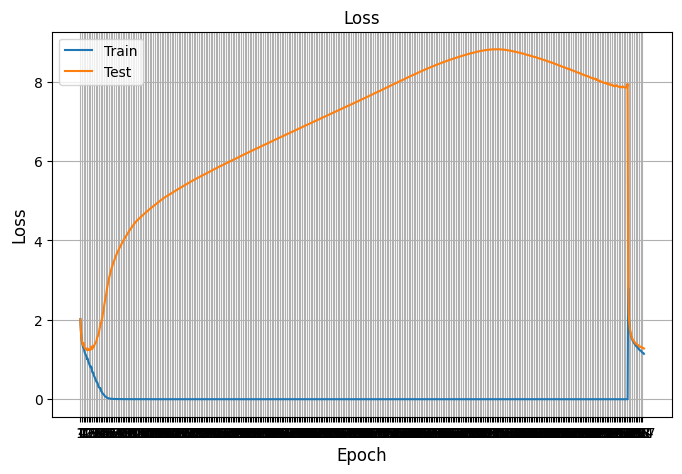

In [105]:
title = 'Loss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_losses, test_losses], [label1, label2], len(train_losses), title, xlabel, ylabel)

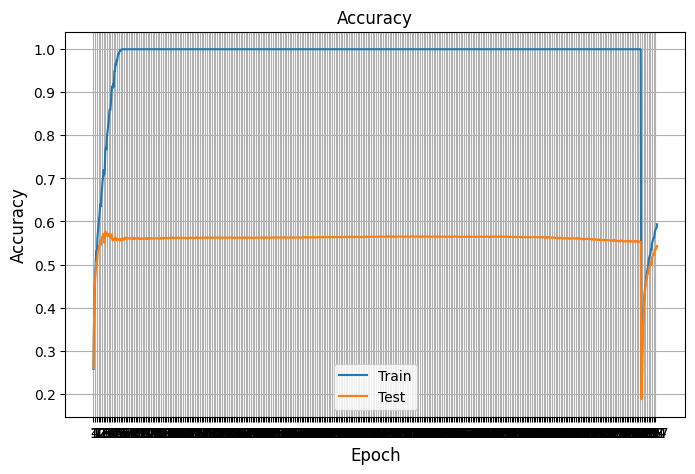

In [106]:
title = 'Accuracy'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Accuracy'
plot([train_accuracies, test_accuracies], [label1, label2], len(train_losses), title, xlabel, ylabel)

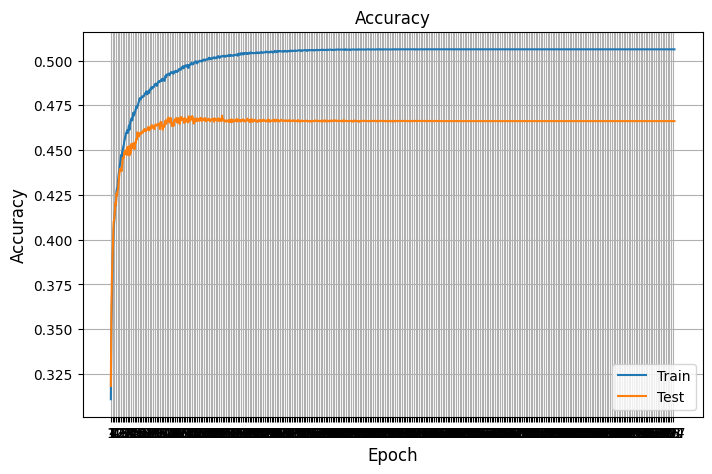

In [702]:
title = 'Accuracy'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Accuracy'
plot([train_accuracies, test_accuracies], [label1, label2], len(train_losses), title, xlabel, ylabel)